# Explore sequence dependence of IME

In [69]:
from datetime import date
print('created 2024-04-07')
print("last updated", date.today())

created 2024-04-07
last updated 2024-06-08


In [70]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from scipy import stats
from scipy.stats import spearmanr
from Levenshtein import distance as lev
from matplotlib import patches as mpatches

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 200

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'
IME_path = outpath+'../../Cluster/IME/'

In [71]:
# load in barcode-to-intron dictionary
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'rb') as f:
    b2i = pickle.load(f)

In [72]:
# load in data from the 2 screens + DESeq2 output
# this table contains only trusted barcodes (≤10% mismatches)
# and only barcodes passing 3 sample filter (≥10 GFP + ≥10 dTom reads)

with open(outpath+"pkls/RIL12only_b2i06min3readclusters_10percentMM_4sampfilter_DESeq2_output.pkl", 'rb') as f:
    df = pickle.load(f)

bcs = list(df.index)
num_reps = 10

GFP_counts = df.values[:,:num_reps]    # DOES NOT include unspliced
dTom_counts = df.values[:,num_reps:num_reps*2]
unspliced_GFP_counts = df.values[:,num_reps*2:num_reps*3]

l2fc = df.PosteriorMean
l2fc_SD = df.PosteriorSD
readcounts = GFP_counts + unspliced_GFP_counts + dTom_counts

p_cutoff = 0.05
sig = df['padj'].values<p_cutoff
pos = df['PosteriorMean'].values>1
neg = df['PosteriorMean'].values<-1

significant = df['padj'].values<0.1
non_significant = ~significant

up_bcs = [b for b in df[sig&pos].index]
down_bcs = [b for b in df[sig&neg].index]
nonsig_bcs = [b for b in df[non_significant].index]

In [73]:
with open(outpath+"pkls/RIL2_iFACS_selected_bc_sets.pkl", 'rb') as f:
    FACS_bc_sets = pickle.load(f)
    
green_bcs, red_bcs, FACS_bg_bcs = FACS_bc_sets['g'], FACS_bc_sets['r'], FACS_bc_sets['bg']
green_mask = np.array([b in green_bcs for b in bcs])
red_mask = np.array([b in red_bcs for b in bcs])
FACS_bg_mask = np.array([b in FACS_bg_bcs for b in bcs])

In [74]:
#def list_to_fasta(listname,filename,seqnames=[]):
#    with open(filename, "w") as output:
#        writer = csv.writer(output, lineterminator='\n')
#        if len(seqnames)==0:
#            seqnames = ['seq'+str(x) for x in range(len(listname))]
#        for name,seq in zip(seqnames,listname):
#            writer.writerow([">"+name])
#            writer.writerow([seq])
#
## export lists for MEME
#
#listnames = ['RNA_up', 'RNA_down', 'RNA_nonsig', 'green', 'red', 'FACS_nonsig']
#lists = [up_bcs, down_bcs, nonsig_bcs, green_bcs, red_bcs, FACS_bg_bcs]
#
#for name, bcs in zip(listnames,lists):
#    list_to_fasta([b2i[b][12:-40] for b in bcs if (b in b2i)&(b not in intronless_barcodes)], 
#                  filename = f'{outpath}intron lists/{name}_introns.fasta')

In [133]:
intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']

UbC_bc = 'ATACCATAACTACCCACT'
spike_in_bcs = intronless_barcodes+[UbC_bc]

intless_mask = [b in intronless_barcodes for b in bcs]
pos_ctrl_mask = [b==UbC_bc for b in bcs]

i_msk = np.array(intless_mask)
intless_baseline = l2fc[i_msk].mean()

intless_upper_bounds = 2**(l2fc[i_msk]+(l2fc_SD[i_msk])/2)
intless_lower_bounds = 2**(l2fc[i_msk]-(l2fc_SD[i_msk])/2)
intless_baseline_SE = (intless_upper_bounds-intless_lower_bounds).mean()

norm_l2fc = np.array(l2fc-intless_baseline)
upper_bounds = 2**(norm_l2fc[~i_msk]+(l2fc_SD[~i_msk])/2)
lower_bounds = 2**(norm_l2fc[~i_msk]-(l2fc_SD[~i_msk])/2)
mean_library_SE = (upper_bounds-lower_bounds).mean()

print(f'The estimated effect of an intronless barcode is to decrease GFP expresion to {2**intless_baseline:.3f}X ± {intless_baseline_SE:.3f} compared to the mean of the library,')
print(f'In other words, compared to an intronless GFP, the average intron in the library increases GFP expresion {2**norm_l2fc[~np.array(intless_mask)].mean():.1f}X ± {mean_library_SE:.1f}.')

The estimated effect of an intronless barcode is to decrease GFP expresion to 0.123X ± 0.131 compared to the mean of the library,
In other words, compared to an intronless GFP, the average intron in the library increases GFP expresion 8.5X ± 1.9.


In [139]:
np.mean(norm_l2fc[~np.array(intless_mask)])

3.095666817996411

In [76]:
nuc_colors = {'A':'green',
             'T':'red',
             'G':'orange',
             'C':'blue'}

nuc_colors2 = {'A':'lime',
             'T':'pink',
             'G':'yellow',
             'C':'cyan'}

In [77]:
import itertools
import numpy as np
import pandas as pd

# Define constants
k = 5
dna = ["A", "G", "C", "T"]

# Generate all possible pentamers
pentamers = sorted([''.join(p) for p in itertools.product(dna, repeat=k)])

# Extract barcodes and intron sequences
all_bcs, intseqs = zip(*[(b, s[8:][:-36]) for b, s in b2i.items()])

# Generate intron pentamer table
intron_pentamers = pd.DataFrame(index=all_bcs, columns=pentamers)

#for p in pentamers:
#    p_counts = []
#    for i in intseqs:
#        p_counts.append(i.count(p))
#    intron_pentamers[p] = p_counts
#
#with (open(outpath+"pkls/intron_pentamer_table.pkl",'wb')) as f:
#    pickle.dump(intron_pentamers,f)

with open(outpath+"pkls/intron_pentamer_table.pkl", 'rb') as f:
    intron_pentamers = pickle.load(f)

detected_intron_pentamers = intron_pentamers.reindex(bcs)

In [78]:
tetramers = sorted([''.join(p) for p in itertools.product(dna, repeat=4)])

# Generate intron tetramer table
intron_tetramers = pd.DataFrame(index=all_bcs, columns=tetramers)

# intron sequences with 3nt flanking
#intseqs = [s[9:][:-37] for b, s in b2i.items()]
#
#for p in tetramers:
#    p_counts = []
#    for i in intseqs:
#        p_counts.append(i.count(p))
#    intron_tetramers[p] = p_counts
#
#with (open(outpath+"pkls/intron_tetramer_table.pkl",'wb')) as f:
#    pickle.dump(intron_tetramers,f)

with open(outpath+"pkls/intron_tetramer_table.pkl", 'rb') as f:
    intron_tetramers = pickle.load(f)

detected_intron_tetramers = intron_tetramers.reindex(bcs)

In [79]:
trimers = sorted([''.join(p) for p in itertools.product(dna, repeat=3)])

# Generate intron tetramer table
intron_trimers = pd.DataFrame(index=all_bcs, columns=trimers)

# intron sequences with 2nt flanking
#intseqs = [s[10:][:-38] for b, s in b2i.items()]
#
#for p in trimers:
#    p_counts = []
#    for i in intseqs:
#        p_counts.append(i.count(p))
#    intron_trimers[p] = p_counts
#
#with (open(outpath+"pkls/intron_trimer_table.pkl",'wb')) as f:
#    pickle.dump(intron_trimers,f)
with open(outpath+"pkls/intron_trimer_table.pkl", 'rb') as f:
    intron_trimers = pickle.load(f)

detected_intron_trimers = intron_trimers.reindex(bcs)

In [80]:
dna_H = ["A", "C", "T"]
pentamers_H = sorted([''.join(p) for p in itertools.product(dna_H, repeat=k)])

bc_pentamers = pd.DataFrame(index=all_bcs, columns=pentamers_H)
for p in pentamers_H:
    p_counts = []
    for b in all_bcs:
        p_counts.append(b.count(p))
    bc_pentamers[p] = p_counts

detected_bc_pentamers = bc_pentamers.reindex(bcs)

# cdfs of introns with different counts of kmer

In [13]:
def bcs_with_nm_of_kmer(n, m, kmer):
    if len(kmer)==5:
        df=detected_intron_pentamers
    elif len(kmer)==4:
        df=detected_intron_tetramers
    elif len(kmer)==3:
        df=detected_intron_trimers
    bcs_of_interest = df.index[(df[kmer]>=n)&(df[kmer]<=m)]
    return [b in bcs_of_interest for b in bcs]

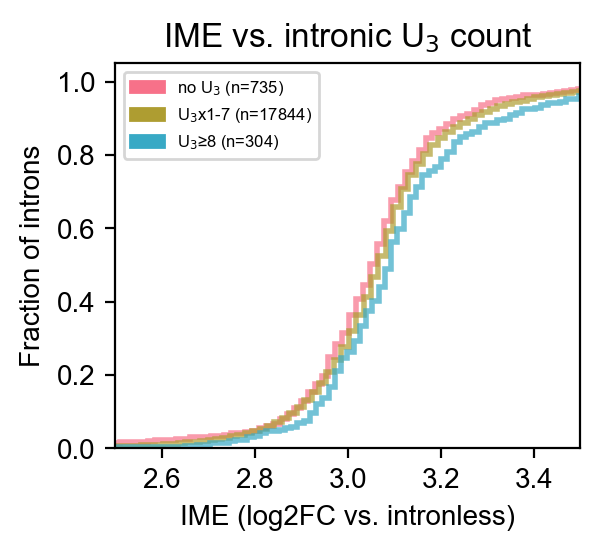

Wilcoxin Rank-Sum statistic 1&2: -2.66, p=0.007858
Wilcoxin Rank-Sum statistic 2&3: -2.95, p=0.003211
Wilcoxin Rank-Sum statistic 1&3: -3.93, p=0.000086


In [131]:
from scipy.stats import ranksums

patches = {}
hdata = {}

plt.figure(figsize=(3,2.5))

steps = [0,1,2]
cmap = sns.color_palette("husl", 5)
xlim = (2.5,3.5)
bins = 100

hdata[0] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,'TTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[0],
         color=cmap[0],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[0] = mpatches.Patch(color=cmap[0], label=f'no U$_3$ (n={len(hdata[0])})')

hdata[1]=[x for x in norm_l2fc[bcs_with_nm_of_kmer(1,7,'TTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[1],
         color=cmap[1],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[1] = mpatches.Patch(color=cmap[1], label=f'U$_3$x1-7 (n={len(hdata[1])})')

hdata[2]=[x for x in norm_l2fc[bcs_with_nm_of_kmer(8,100,'TTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[2],
         color=cmap[3],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[2] = mpatches.Patch(color=cmap[3], label=f'U$_3$≥8 (n={len(hdata[2])})')

plt.legend(handles = patches.values(), fontsize=6)

plt.ylabel('Fraction of introns')
plt.xlabel('IME (log2FC vs. intronless)')
plt.title('IME vs. intronic U$_3$ count')

plt.xlim(xlim)
plt.show()

for i,j in [(0,1),(1,2),(0,2)]:
    rs = ranksums(hdata[i],hdata[j])
    print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs[0]:.2f}, p={rs[1]:.6f}')

In [132]:
[((np.median(hdata[x])))-((np.median(hdata[x-1]))) for x in [1,2]]

[0.014434826019678937, 0.018840030363744376]

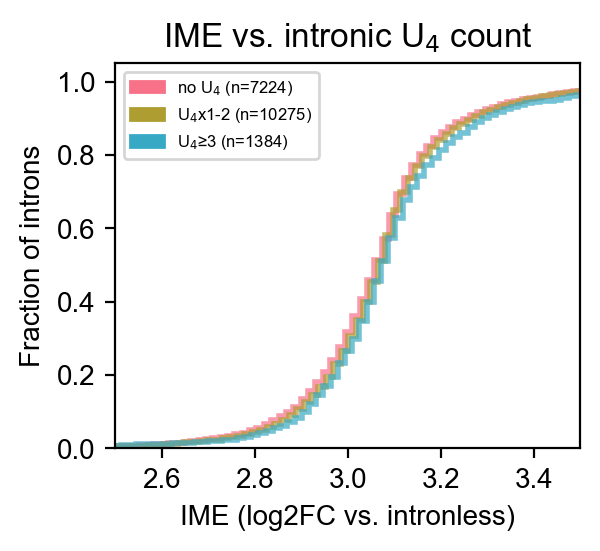

Wilcoxin Rank-Sum statistic 1&2: -4.32, p=0.000015
Wilcoxin Rank-Sum statistic 2&3: -2.86, p=0.004223
Wilcoxin Rank-Sum statistic 1&3: -5.00, p=0.000001


In [126]:
patches = {}
hdata={}

plt.figure(figsize=(3,2.5))

steps = [0,1,2]
cmap = sns.color_palette("husl", 5)
xlim = (2.5,3.5)
bins = 100

hdata[0] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,'TTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[0], 
         color=cmap[0],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[0] = mpatches.Patch(color=cmap[0], label=f'no U$_4$ (n={len(hdata[0])})')

hdata[1] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(1,2,'TTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[1],         
         color=cmap[1],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[1] = mpatches.Patch(color=cmap[1], label=f'U$_4$x1-2 (n={len(hdata[1])})')

hdata[2] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(3,100,'TTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[2],
         color=cmap[3],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[2] = mpatches.Patch(color=cmap[3], label=f'U$_4$≥3 (n={len(hdata[2])})')

plt.legend(handles = patches.values(), fontsize=6)

plt.ylabel('Fraction of introns')
plt.xlabel('IME (log2FC vs. intronless)')
plt.title('IME vs. intronic U$_4$ count')

plt.xlim(xlim)
plt.show()

for i,j in [(0,1),(1,2),(0,2)]:
    rs = ranksums(hdata[i],hdata[j])
    print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs[0]:.2f}, p={rs[1]:.6f}')

In [127]:
[(2**(np.median(hdata[x])))-(2**(np.median(hdata[x-1]))) for x in [1,2]]

[0.04576513666562043, 0.039283034593740496]

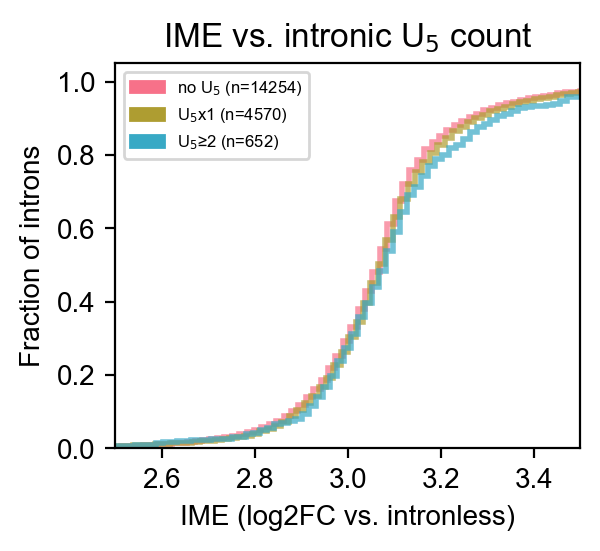

Wilcoxin Rank-Sum statistic 1&2: -3.66, p=0.000252
Wilcoxin Rank-Sum statistic 2&3: -1.55, p=0.121707
Wilcoxin Rank-Sum statistic 1&3: -3.13, p=0.001759


In [128]:
patches = {}
hdata = {}

plt.figure(figsize=(3,2.5))

steps = [0,1,2]
cmap = sns.color_palette("husl", 5)
xlim = (2.5,3.5)
bins = 100

hdata[0] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,'TTTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[0], 
         color=cmap[0],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[0] = mpatches.Patch(color=cmap[0], label=f'no U$_5$ (n={len(hdata[0])})')

hdata[1] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(1,2,'TTTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[1],         
         color=cmap[1],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[1] = mpatches.Patch(color=cmap[1], label=f'U$_5$x1 (n={len(hdata[1])})')

hdata[2] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(2,100,'TTTTT')] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
plt.hist(hdata[2],
         color=cmap[3],bins=bins, 
         cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
patches[2] = mpatches.Patch(color=cmap[3], label=f'U$_5$≥2 (n={len(hdata[2])})')

plt.legend(handles = patches.values(), fontsize=6)

plt.ylabel('Fraction of introns')
plt.xlabel('IME (log2FC vs. intronless)')
plt.title('IME vs. intronic U$_5$ count')

plt.xlim(xlim)
plt.show()

for i,j in [(0,1),(1,2),(0,2)]:
    rs = ranksums(hdata[i],hdata[j])
    print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs[0]:.2f}, p={rs[1]:.6f}')

In [130]:
[((np.median(hdata[x])))-((np.median(hdata[x-1]))) for x in [1,2]]

[0.006108906128194036, 0.0065517648817934315]

In [18]:
def kmer_count_cdfs(kmer, kmax=3):
    patches = {}
    hdata={}
    cmap = sns.color_palette("husl", 5)
    xlim = (2.5,3.5)
    bins = 100
    
    plt.figure(figsize=(3,2.5))
    hdata[0] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,kmer)] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
    plt.hist(hdata[0], 
             color=cmap[0],bins=bins, 
             cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
    patches[0] = mpatches.Patch(color=cmap[0], label=f'no {kmer} (n={len(hdata[0])})')
    
    hdata[1] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(1,kmax-1,kmer)] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
    plt.hist(hdata[1],         
             color=cmap[1],bins=bins, 
             cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
    patches[1] = mpatches.Patch(color=cmap[1], label=f'{kmer}x1-{kmax-1} (n={len(hdata[1])})')
    
    hdata[2] =[x for x in norm_l2fc[bcs_with_nm_of_kmer(kmax,10,kmer)] if (x>=xlim[0]*0.9)&(x<=xlim[1]*1.1)]
    plt.hist(hdata[2],
             color=cmap[3],bins=bins, 
             cumulative=True, density=True, alpha=0.7, histtype='step', linewidth=2)
    patches[2] = mpatches.Patch(color=cmap[3], label=f'{kmer}≥{kmax} (n={len(hdata[2])})')
    
    plt.legend(handles = patches.values(), fontsize=6)
    
    plt.ylabel('Fraction of introns')
    plt.xlabel('IME (log2FC vs. intronless)')
    plt.title(f'IME vs. intronic {kmer} count')
    
    plt.xlim(xlim)
    plt.show()

In [19]:
trimer_scores = []
sig_trimers = {}
for t in trimers:
    IME_dist = {}
    rs_results = {}
    IME_dist[0] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,t)]]
    IME_dist[1] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(1,5,t)]]
    IME_dist[2] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(6,100,t)]]
    for i,j in [(0,1),(1,2),(0,2)]:
        rs_results[(i,j)] = ranksums(IME_dist[i],IME_dist[j])
        
    if all(v[1]<0.1 for v in rs_results.values()):
        t_stat_sum = np.sum([v[0] for v in rs_results.values()])
        trimer_scores.append((t_stat_sum,t))
        sig_trimers[t] = rs_results

POSITIVE IME KMERS:
TTT
Wilcoxin Rank-Sum statistic 1&2: -3.18, p=0.001476
Wilcoxin Rank-Sum statistic 2&3: -5.31, p=0.000000
Wilcoxin Rank-Sum statistic 1&3: -5.64, p=0.000000


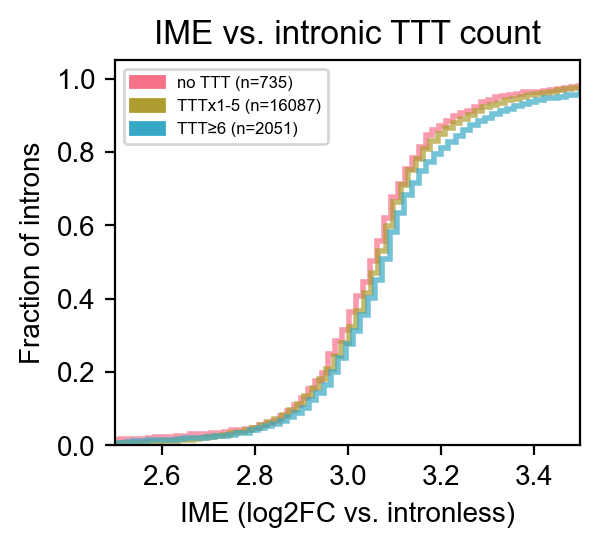



NEGATIVE IME KMERS:
TCA
Wilcoxin Rank-Sum statistic 1&2: 2.02, p=0.043239
Wilcoxin Rank-Sum statistic 2&3: 3.44, p=0.000591
Wilcoxin Rank-Sum statistic 1&3: 4.02, p=0.000059


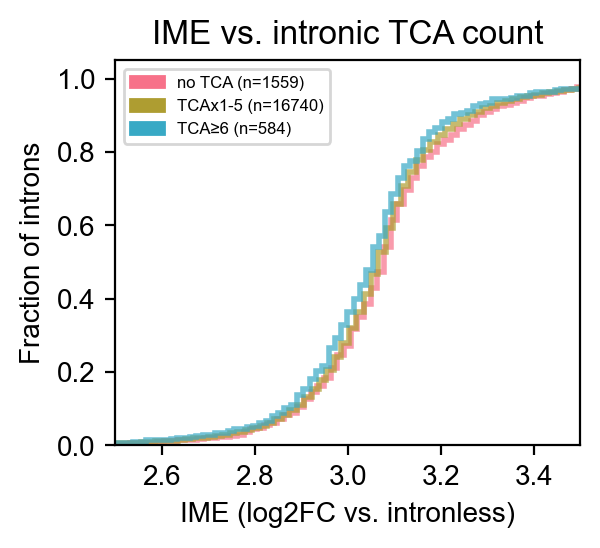

In [20]:
print('POSITIVE IME KMERS:')
for s,t in sorted(trimer_scores)[:1]:
    if s<0:
        print(t)
        rs_results = sig_trimers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t, kmax=6)

print('\n\nNEGATIVE IME KMERS:')
for s,t in sorted(trimer_scores, reverse=True)[:1]:
    if s>0:
        print(t)
        rs_results = sig_trimers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t, kmax=6)

In [21]:
tetramer_scores = []
sig_tetramers = {}
for t in tetramers:
    IME_dist = {}
    rs_results = {}
    IME_dist[0] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,t)]]
    IME_dist[1] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(1,2,t)]]
    IME_dist[2] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(3,100,t)]]
    for i,j in [(0,1),(1,2),(0,2)]:
        rs_results[(i,j)] = ranksums(IME_dist[i],IME_dist[j])
        
    if all(v[1]<0.1 for v in rs_results.values()):
        t_stat_sum = np.sum([v[0] for v in rs_results.values()])
        tetramer_scores.append((t_stat_sum,t))
        sig_tetramers[t] = rs_results

POSITIVE IME KMERS:
TTTT
Wilcoxin Rank-Sum statistic 1&2: -5.06, p=0.000000
Wilcoxin Rank-Sum statistic 2&3: -2.62, p=0.008673
Wilcoxin Rank-Sum statistic 1&3: -5.18, p=0.000000


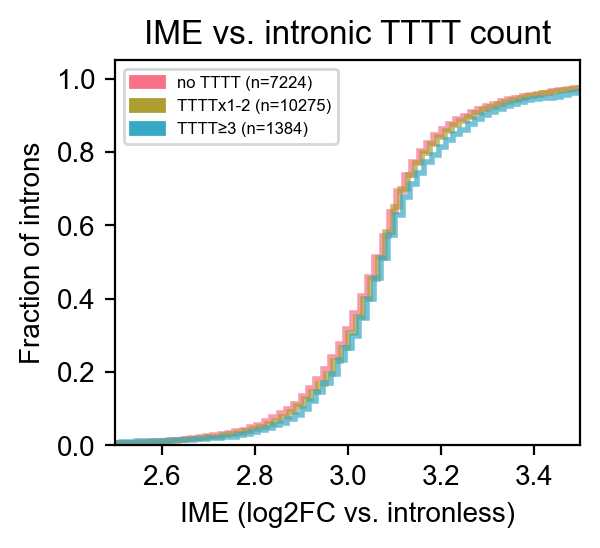



NEGATIVE IME KMERS:
TGAC
Wilcoxin Rank-Sum statistic 1&2: 3.14, p=0.001683
Wilcoxin Rank-Sum statistic 2&3: 3.69, p=0.000226
Wilcoxin Rank-Sum statistic 1&3: 4.58, p=0.000005


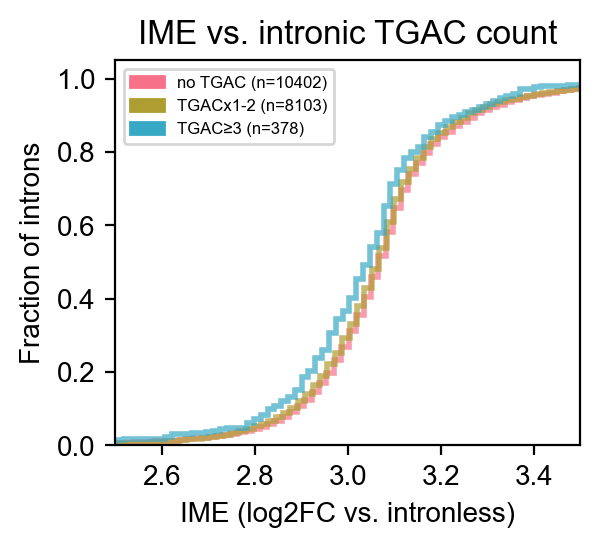

In [22]:
print('POSITIVE IME KMERS:')
for s,t in sorted(tetramer_scores)[:1]:
    if s<0:
        print(t)
        rs_results = sig_tetramers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t)

print('\n\nNEGATIVE IME KMERS:')
for s,t in sorted(tetramer_scores, reverse=True)[:1]:
    if s>0:
        print(t)
        rs_results = sig_tetramers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t)

In [23]:
pentamer_scores = []
sig_pentamers = {}
for p in pentamers:
    IME_dist = {}
    rs_results = {}
    IME_dist[0] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,p)]]
    IME_dist[1] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(1,1,p)]]
    IME_dist[2] = [x for x in norm_l2fc[bcs_with_nm_of_kmer(2,10,p)]]
    for i,j in [(0,1),(1,2),(0,2)]:
        rs_results[(i,j)] = ranksums(IME_dist[i],IME_dist[j])
        
    if all(v[1]<0.1 for v in rs_results.values()):
        p_stat_sum = np.sum([v[0] for v in rs_results.values()])
        pentamer_scores.append((p_stat_sum,p))
        sig_pentamers[p] = rs_results

POSITIVE IME KMERS:
TTTTT
Wilcoxin Rank-Sum statistic 1&2: -3.07, p=0.002117
Wilcoxin Rank-Sum statistic 2&3: -2.04, p=0.041405
Wilcoxin Rank-Sum statistic 1&3: -3.48, p=0.000493


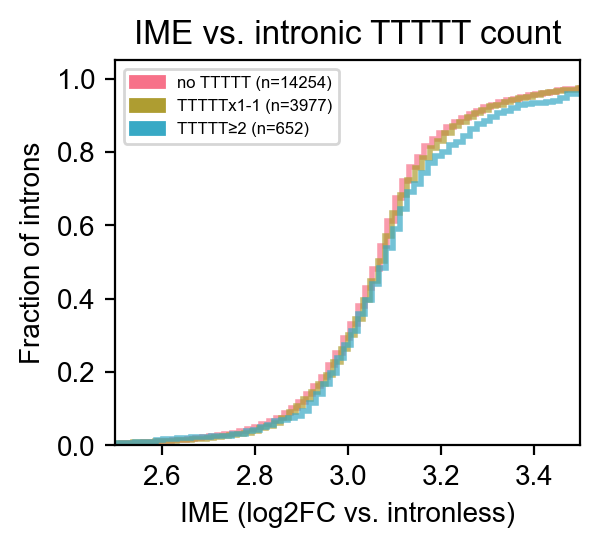

TCTTT
Wilcoxin Rank-Sum statistic 1&2: -3.22, p=0.001297
Wilcoxin Rank-Sum statistic 2&3: -1.81, p=0.071032
Wilcoxin Rank-Sum statistic 1&3: -3.24, p=0.001195


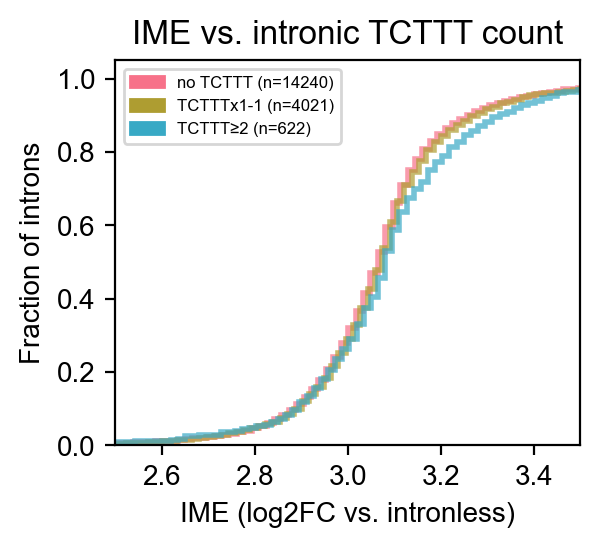

TCGTT
Wilcoxin Rank-Sum statistic 1&2: -1.78, p=0.074783
Wilcoxin Rank-Sum statistic 2&3: -2.74, p=0.006204
Wilcoxin Rank-Sum statistic 1&3: -3.53, p=0.000409


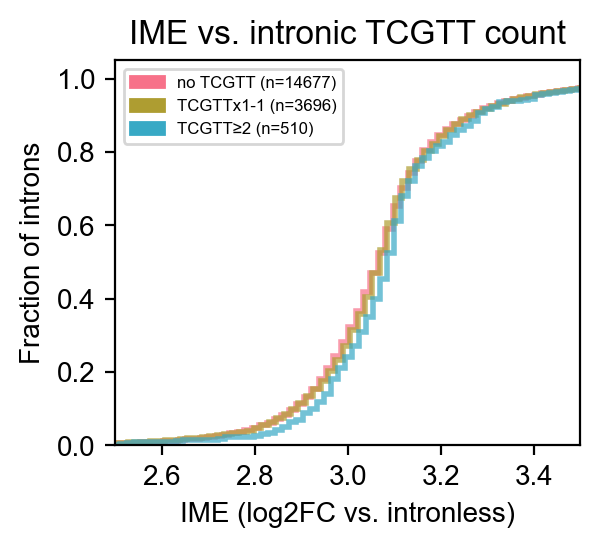



NEGATIVE IME KMERS:
GTCAT
Wilcoxin Rank-Sum statistic 1&2: 3.01, p=0.002574
Wilcoxin Rank-Sum statistic 2&3: 1.82, p=0.068418
Wilcoxin Rank-Sum statistic 1&3: 2.90, p=0.003695


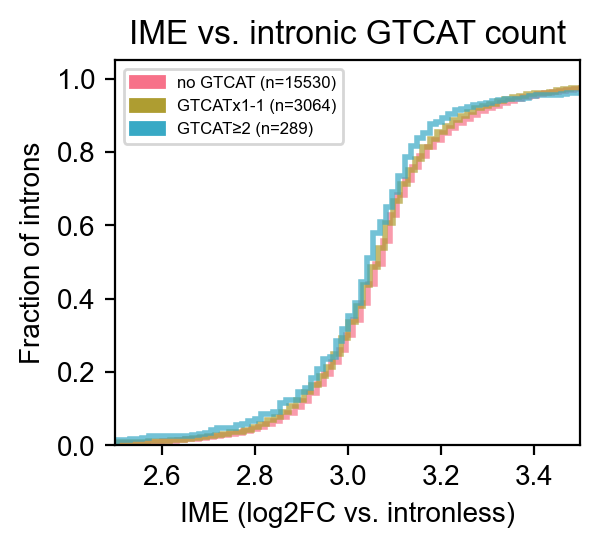

In [24]:
print('POSITIVE IME KMERS:')
for s,t in sorted(pentamer_scores)[:3]:
    if s<0:
        print(t)
        rs_results = sig_pentamers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t, kmax=2)

print('\n\nNEGATIVE IME KMERS:')
for s,t in sorted(pentamer_scores, reverse=True)[:1]:
    if s>0:
        print(t)
        rs_results = sig_pentamers[t]
        for i,j in [(0,1),(1,2),(0,2)]:
            print(f'Wilcoxin Rank-Sum statistic {i+1}&{j+1}: {rs_results[(i,j)][0]:.2f}, p={rs_results[(i,j)][1]:.6f}')
        kmer_count_cdfs(t, kmax=2)

# effect size estimates for with vs. without?

In [97]:
tetramer_scores = []
for t in tetramers:
    IME_without = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,t)]]
    IME_with = [x for x in norm_l2fc[bcs_with_nm_of_kmer(1,20,t)]]
    rs = ranksums(IME_without,IME_with)
    if rs[1]<0.05:
        tetramer_scores.append((rs[0],t,rs[1], np.median(IME_without), np.median(IME_with)))

In [114]:
# Extract p-values
p_values = np.array([score[2] for score in tetramer_scores])

# Benjamini-Hochberg (BH) correction
sorted_p_values = np.sort(p_values)
sorted_p_index = np.argsort(p_values)
bh_thresholds = [((i + 1) / len(p_values)) * p_val_cutoff for i in range(len(p_values))]

bh_corrected_p = np.zeros_like(p_values)
for i in range(len(p_values)):
    bh_corrected_p[sorted_p_index[i]] = sorted_p_values[i] <= bh_thresholds[i]

# Significant kmers after corrections
significant_kmers_bh = [score for i, score in enumerate(tetramer_scores) if bh_corrected_p[i]]

i=0
for s,t,p,mwo,mw in sorted(significant_kmers_bh):
    if i==0 and s>0:
        print()
        i+=1
    print(f'{t}, {(2**mw)-(2**mwo):.6f}, {p:.1e}')

TTTT, 0.057952, 7.8e-09
CTTT, 0.057773, 6.1e-07
TTTA, 0.053544, 4.9e-06
TTTC, 0.048900, 3.5e-05
TCTT, 0.039421, 4.4e-05
TTAG, 0.040212, 1.5e-04
TTCG, 0.041509, 2.7e-04
TACT, 0.045344, 5.6e-04
TAGC, 0.030423, 9.8e-04
TCGT, 0.029616, 1.0e-03
GTTT, 0.029226, 1.1e-03
TTTG, 0.042620, 1.3e-03
ATTT, 0.042038, 2.0e-03
CGGG, 0.023268, 2.0e-03
TTCT, 0.016960, 3.3e-03

CATC, -0.033815, 3.8e-03
ACAC, -0.029664, 2.8e-03
TCAT, -0.030978, 2.4e-03
CAAA, -0.031565, 2.2e-03
GACA, -0.025017, 7.2e-04
GACG, -0.023542, 4.4e-04
TCAC, -0.039877, 3.0e-04
CATG, -0.038482, 2.1e-04
TGAC, -0.028869, 1.6e-04
ACAA, -0.041167, 8.4e-05
GTCA, -0.041673, 1.0e-05


In [106]:
pentamer_scores = []
for p in pentamers:
    IME_without = [x for x in norm_l2fc[bcs_with_nm_of_kmer(0,0,p)]]
    IME_with = [x for x in norm_l2fc[bcs_with_nm_of_kmer(1,20,p)]]
    rs = ranksums(IME_without,IME_with)
    if rs[1]<0.05:
        pentamer_scores.append((rs[0],p,rs[1], np.median(IME_without), np.median(IME_with)))

In [115]:
# Extract p-values
p_values = np.array([score[2] for score in pentamer_scores])

# Benjamini-Hochberg (BH) correction
sorted_p_values = np.sort(p_values)
sorted_p_index = np.argsort(p_values)
bh_thresholds = [((i + 1) / len(p_values)) * p_val_cutoff for i in range(len(p_values))]

bh_corrected_p = np.zeros_like(p_values)
for i in range(len(p_values)):
    bh_corrected_p[sorted_p_index[i]] = sorted_p_values[i] <= bh_thresholds[i]

# Significant kmers after corrections
significant_kmers_bh = [score for i, score in enumerate(pentamer_scores) if bh_corrected_p[i]]

i=0
for s,t,p,mwo,mw in sorted(significant_kmers_bh):
    if i==0 and s>0:
        print()
        i+=1
    print(f'{t}, {(2**mw)-(2**mwo):.6f}, {p:.1e}')

ATTTT, 0.043471, 3.7e-06
TTTAG, 0.044795, 1.5e-05
CTTTT, 0.047573, 1.7e-05
TTTTG, 0.043435, 2.7e-05
GTTTT, 0.031889, 5.7e-05
TCTTT, 0.048961, 6.5e-05
TTTTT, 0.042597, 7.4e-05
TTTTA, 0.035097, 2.9e-04
ACTTT, 0.043446, 5.5e-04
CTACT, 0.051931, 6.9e-04
TTTTC, 0.031195, 7.4e-04
TTTGG, 0.041165, 8.1e-04
GATTT, 0.041746, 8.5e-04
TTTCT, 0.036235, 9.3e-04
ATTCG, 0.040334, 1.4e-03
GGTTT, 0.015513, 1.7e-03
TTTGT, 0.032425, 2.2e-03
AGAAA, 0.055629, 2.2e-03

CATGC, -0.055288, 2.5e-03
ACAAG, -0.042216, 2.4e-03
TCAAA, -0.050433, 2.0e-03
GTCGA, -0.036194, 2.0e-03
ATATC, -0.033883, 2.0e-03
CAGTC, -0.050051, 2.0e-03
TACCT, -0.067950, 1.6e-03
GACGT, -0.038085, 1.0e-03
ACACC, -0.067936, 9.4e-04
CAAAC, -0.067005, 5.8e-04
GCAGT, -0.061978, 5.2e-04
CATCA, -0.049226, 4.5e-04
GTCAT, -0.055315, 2.8e-04
GTCAC, -0.053510, 2.3e-04
CACCC, -0.074661, 2.0e-04
CGTAA, -0.066739, 1.1e-04
TGTCA, -0.050129, 4.1e-05
TGACA, -0.061726, 1.7e-05
TGACG, -0.055070, 6.5e-06
GTCAA, -0.054971, 3.9e-06
CGTCA, -0.080331, 1.0e-06


In [112]:
2**3.007419

8.041245632551743

# kmer spearman corr w IME

In [81]:
# see if any kmers are significantly correlated with IME

from scipy.stats import spearmanr
p_val_cutoff = 0.01

In [116]:
kmer_df = detected_intron_trimers

correlations = {}
for kmer in kmer_df.columns:
    corr, p_value = spearmanr(kmer_df[kmer], norm_l2fc)
    correlations[kmer] = (corr, p_value)

# Extract p-values
p_values = np.array([correlations[kmer][1] for kmer in correlations])

# Bonferroni correction
bonferroni_corrected_p = p_values * len(p_values)
bonferroni_corrected_p = np.minimum(bonferroni_corrected_p, 1)  # Ensure p-values do not exceed 1

# Benjamini-Hochberg (BH) correction
sorted_p_values = np.sort(p_values)
sorted_p_index = np.argsort(p_values)
bh_thresholds = [((i + 1) / len(p_values)) * p_val_cutoff for i in range(len(p_values))]

bh_corrected_p = np.zeros_like(p_values)
for i in range(len(p_values)):
    bh_corrected_p[sorted_p_index[i]] = sorted_p_values[i] <= bh_thresholds[i]

# Significant kmers after corrections
significant_kmers_bonferroni = [kmer for i, kmer in enumerate(correlations) if bonferroni_corrected_p[i] < p_val_cutoff]
significant_kmers_bh = [kmer for i, kmer in enumerate(correlations) if bh_corrected_p[i]]

print(f'Significant k-mers with no MHT correction: {[kmer for i, kmer in enumerate(correlations) if p_values[i] < p_val_cutoff]}')
print(f'\nSignificant k-mers after Bonferroni correction:')
for k in significant_kmers_bonferroni:
    print(f'{k}, spearman r = {correlations[k][0]:.4f}, p = {correlations[k][1]:.2e}')
print(f'\nSignificant k-mers after Benjamini-Hochberg correction:')
for k in significant_kmers_bh:
    print(f'{k}, {correlations[k][0]:.4f}, {correlations[k][1]:.2e}')

Significant k-mers with no MHT correction: ['ACA', 'ACG', 'ACT', 'AGG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CTA', 'CTT', 'GAC', 'GGG', 'GTC', 'TAG', 'TCA', 'TCG', 'TCT', 'TTA', 'TTC', 'TTG', 'TTT']

Significant k-mers after Bonferroni correction:
ACA, spearman r = -0.0375, p = 1.86e-07
CAA, spearman r = -0.0337, p = 2.70e-06
CAC, spearman r = -0.0317, p = 1.04e-05
CAG, spearman r = -0.0313, p = 1.37e-05
TCA, spearman r = -0.0421, p = 4.86e-09
TCT, spearman r = 0.0336, p = 3.04e-06
TTA, spearman r = 0.0276, p = 1.24e-04
TTT, spearman r = 0.0550, p = 2.00e-14

Significant k-mers after Benjamini-Hochberg correction:
ACA, -0.0375, 1.86e-07
ACG, -0.0231, 1.30e-03
AGG, -0.0257, 3.58e-04
ATT, 0.0259, 3.07e-04
CAA, -0.0337, 2.70e-06
CAC, -0.0317, 1.04e-05
CAG, -0.0313, 1.37e-05
CAT, -0.0266, 2.12e-04
CCA, -0.0264, 2.45e-04
CCC, -0.0241, 7.92e-04
CTA, 0.0253, 4.27e-04
CTT, 0.0268, 1.92e-04
GAC, -0.0246, 6.35e-04
GTC, -0.0270, 1.76e-04
TCA, -0.0421, 4.86e-09
TCG, 0.0258, 3.28e-04
T

In [117]:
kmer_df = detected_intron_tetramers

correlations = {}
for kmer in kmer_df.columns:
    corr, p_value = spearmanr(kmer_df[kmer], norm_l2fc)
    correlations[kmer] = (corr, p_value)

# Extract p-values
p_values = np.array([correlations[kmer][1] for kmer in correlations])

# Bonferroni correction
bonferroni_corrected_p = p_values * len(p_values)
bonferroni_corrected_p = np.minimum(bonferroni_corrected_p, 1)  # Ensure p-values do not exceed 1

# Benjamini-Hochberg (BH) correction
sorted_p_values = np.sort(p_values)
sorted_p_index = np.argsort(p_values)
bh_thresholds = [((i + 1) / len(p_values)) * p_val_cutoff for i in range(len(p_values))]

bh_corrected_p = np.zeros_like(p_values)
for i in range(len(p_values)):
    bh_corrected_p[sorted_p_index[i]] = sorted_p_values[i] <= bh_thresholds[i]

# Significant kmers after corrections
significant_kmers_bonferroni = [kmer for i, kmer in enumerate(correlations) if bonferroni_corrected_p[i] < p_val_cutoff]
significant_kmers_bh = [kmer for i, kmer in enumerate(correlations) if bh_corrected_p[i]]

print(f'Significant k-mers with no MHT correction: {[kmer for i, kmer in enumerate(correlations) if p_values[i] < p_val_cutoff]}')
print(f'\nSignificant k-mers after Bonferroni correction:')
for k in significant_kmers_bonferroni:
    print(f'{k}, spearman r = {correlations[k][0]:.4f}, p = {correlations[k][1]:.2e}')
print(f'\nSignificant k-mers after Benjamini-Hochberg correction:')
for k in significant_kmers_bh:
    print(f'{k}, {correlations[k][0]:.4f}, {correlations[k][1]:.2e}')

Significant k-mers with no MHT correction: ['AAAT', 'AACA', 'ACAA', 'ACAC', 'ACCT', 'ACGT', 'ACTT', 'AGGC', 'ATCA', 'ATCG', 'ATTT', 'CAAA', 'CACA', 'CATC', 'CATG', 'CGCC', 'CGGG', 'CTTT', 'GACA', 'GACG', 'GATT', 'GTCA', 'GTTT', 'TACT', 'TAGC', 'TCAC', 'TCAT', 'TCGT', 'TCTT', 'TGAC', 'TTAG', 'TTCG', 'TTCT', 'TTGG', 'TTTA', 'TTTC', 'TTTG', 'TTTT']

Significant k-mers after Bonferroni correction:
ACAA, spearman r = -0.0300, p = 2.99e-05
CTTT, spearman r = 0.0377, p = 1.60e-07
GTCA, spearman r = -0.0414, p = 8.52e-09
GTTT, spearman r = 0.0338, p = 2.51e-06
TCGT, spearman r = 0.0299, p = 3.21e-05
TCTT, spearman r = 0.0328, p = 5.08e-06
TGAC, spearman r = -0.0314, p = 1.26e-05
TTCT, spearman r = 0.0302, p = 2.61e-05
TTTA, spearman r = 0.0369, p = 2.83e-07
TTTG, spearman r = 0.0311, p = 1.50e-05
TTTT, spearman r = 0.0491, p = 7.96e-12

Significant k-mers after Benjamini-Hochberg correction:
ACAA, -0.0300, 2.99e-05
ATTT, 0.0267, 2.03e-04
CATG, -0.0240, 8.38e-04
CTTT, 0.0377, 1.60e-07
GACA, -0.

In [118]:
kmer_df = detected_intron_pentamers

correlations = {}
for kmer in kmer_df.columns:
    corr, p_value = spearmanr(kmer_df[kmer], norm_l2fc)
    correlations[kmer] = (corr, p_value)

# Extract p-values
p_values = np.array([correlations[kmer][1] for kmer in correlations])

# Bonferroni correction
bonferroni_corrected_p = p_values * len(p_values)
bonferroni_corrected_p = np.minimum(bonferroni_corrected_p, 1)  # Ensure p-values do not exceed 1

# Benjamini-Hochberg (BH) correction
sorted_p_values = np.sort(p_values)
sorted_p_index = np.argsort(p_values)
bh_thresholds = [((i + 1) / len(p_values)) * p_val_cutoff for i in range(len(p_values))]

bh_corrected_p = np.zeros_like(p_values)
for i in range(len(p_values)):
    bh_corrected_p[sorted_p_index[i]] = sorted_p_values[i] <= bh_thresholds[i]

# Significant kmers after corrections
significant_kmers_bonferroni = [kmer for i, kmer in enumerate(correlations) if bonferroni_corrected_p[i] < p_val_cutoff]
significant_kmers_bh = [kmer for i, kmer in enumerate(correlations) if bh_corrected_p[i]]

print(f'Significant k-mers with no MHT correction: {[kmer for i, kmer in enumerate(correlations) if p_values[i] < p_val_cutoff]}')
print(f'\nSignificant k-mers after Bonferroni correction:')
for k in significant_kmers_bonferroni:
    print(f'{k}, spearman r = {correlations[k][0]:.4f}, p = {correlations[k][1]:.2e}')
print(f'\nSignificant k-mers after Benjamini-Hochberg correction:')
for k in significant_kmers_bh:
    print(f'{k}, {correlations[k][0]:.4f}, {correlations[k][1]:.2e}')

Significant k-mers with no MHT correction: ['AAAAT', 'AAACA', 'AACAA', 'ACAAC', 'ACAAG', 'ACACC', 'ACCTC', 'ACTTT', 'AGAAA', 'AGGCA', 'ATATC', 'ATTCG', 'ATTTT', 'CAAAC', 'CACAA', 'CACCC', 'CAGTC', 'CATCA', 'CATGC', 'CCAAG', 'CCAGG', 'CCCAA', 'CCCTT', 'CGTAA', 'CGTCA', 'CTAAA', 'CTACT', 'CTAGC', 'CTTTT', 'GAACT', 'GACAA', 'GACGT', 'GATCG', 'GATTT', 'GCAGT', 'GGCCT', 'GGTTT', 'GTCAA', 'GTCAC', 'GTCAT', 'GTCGA', 'GTTTA', 'GTTTT', 'TACCT', 'TCAAA', 'TCATG', 'TCGTG', 'TCGTT', 'TCTAA', 'TCTTT', 'TGACA', 'TGACG', 'TGTCA', 'TTCGG', 'TTCGT', 'TTCTT', 'TTGAC', 'TTTAA', 'TTTAG', 'TTTCG', 'TTTCT', 'TTTGG', 'TTTGT', 'TTTTA', 'TTTTC', 'TTTTG', 'TTTTT']

Significant k-mers after Bonferroni correction:
ATTTT, spearman r = 0.0326, p = 5.62e-06
CGTCA, spearman r = -0.0350, p = 1.13e-06
GTCAA, spearman r = -0.0333, p = 3.61e-06
TGACG, spearman r = -0.0328, p = 4.98e-06

Significant k-mers after Benjamini-Hochberg correction:
ATTTT, 0.0326, 5.62e-06
CGTAA, -0.0276, 1.22e-04
CGTCA, -0.0350, 1.13e-06
CTTTT,

# random forest

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = kmer_df.values
y = norm_l2fc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

KeyboardInterrupt: 

In [439]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import Parallel, delayed

def permutation_test(X, y, model, n_permutations=100, n_jobs=-1):
    original_score = model.score(X, y)
    
    def permuted_score(_):
        permuted_y = np.random.permutation(y)
        model.fit(X, permuted_y)
        return model.score(X, permuted_y)
    
    permuted_scores = Parallel(n_jobs=n_jobs)(delayed(permuted_score)(i) for i in range(n_permutations))
    
    p_value = np.mean(np.array(permuted_scores) >= original_score)
    return original_score, permuted_scores, p_value
    
original_score, permuted_scores, p_value = permutation_test(X_train, y_train, model)
print(f'Original Score: {original_score}, Permutation p-value: {p_value}')

KeyboardInterrupt: 

# compute relative kmer frequences between sets

In [46]:
def get_relative_pentamer_frequencies(foreground, background, kmers=pentamers):
    rel_freqs = {p:0 for p in kmers}
    
    # Ensure both are numpy arrays
    foreground = np.asarray(foreground)
    background = np.asarray(background)

    # Check if shapes match
    if foreground.shape != background.shape:
        raise ValueError("Shapes of foreground and background do not match.")
    
    # Perform element-wise division and handle division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_frequencies = np.divide(foreground, background)
        relative_frequencies[np.isnan(relative_frequencies)] = 0  # Replace NaNs with 0
        relative_frequencies[np.isinf(relative_frequencies)] = 0  # Replace Infs with 0
    
    # Compute log2 of the relative frequencies and pair with pentamers
    for p,f in zip(kmers, relative_frequencies):
        rel_freqs[p] = np.log2(f)
    return rel_freqs

In [47]:
# Initialize dictionary to store frequencies
intset_p_freqs = {}

# Compute normalized frequencies
for name, mask in zip(['up', 'down', 'nonsig', 
                       'green', 'red', 'FACS_nonsig'],
                      [sig & pos, sig & neg, non_significant, 
                       green_mask, red_mask, FACS_bg_mask]):
    counts = np.sum(detected_intron_pentamers[mask], axis=0)
    freqs = counts/(np.sum(mask))
    intset_p_freqs[name] = freqs

# Manually adjust min to avoid division by zero
#intset_p_freqs['down'][intset_p_freqs['down'] == 0] = 0.03

# Compute relative frequencies
up_non = get_relative_pentamer_frequencies(intset_p_freqs['up'], intset_p_freqs['nonsig'])
up_down = get_relative_pentamer_frequencies(intset_p_freqs['up'], intset_p_freqs['down'])
green_red = get_relative_pentamer_frequencies(intset_p_freqs['green'], intset_p_freqs['red'])
green_non = get_relative_pentamer_frequencies(intset_p_freqs['green'], intset_p_freqs['FACS_nonsig'])

#dicthead(up_non)

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_98935/119638968.py:20: RuntimeWarning: divide by zero encountered in log2
  rel_freqs[p] = np.log2(f)


In [48]:
# Initialize dictionary to store frequencies
intset_t_freqs = {}

# Compute normalized frequencies
for name, mask in zip(['up', 'down', 'nonsig', 'green', 'red', 'FACS_nonsig'],
                      [sig & pos, sig & neg, non_significant, green_mask, red_mask, FACS_bg_mask]):
    counts = np.sum(detected_intron_tetramers[mask], axis=0)
    total_counts = np.sum(counts)
    intset_t_freqs[name] = counts / total_counts if total_counts > 0 else counts

# Manually adjust min to avoid division by zero
#intset_p_freqs['down'][intset_p_freqs['down'] == 0] = 0.03

# Compute relative frequencies
up_non_4 = get_relative_pentamer_frequencies(intset_t_freqs['up'], intset_t_freqs['nonsig'], kmers=tetramers)
up_down_4 = get_relative_pentamer_frequencies(intset_t_freqs['up'], intset_t_freqs['down'], kmers=tetramers)
green_red_4 = get_relative_pentamer_frequencies(intset_t_freqs['green'], intset_t_freqs['red'], kmers=tetramers)
green_non_4 = get_relative_pentamer_frequencies(intset_t_freqs['green'], intset_t_freqs['FACS_nonsig'], kmers=tetramers)

#dicthead(up_non)

In [49]:
# Initialize dictionary to store frequencies
detected_bc_pentamers = bc_pentamers.loc[bcs]
bcset_p_freqs = {}

# Compute normalized frequencies
for name, mask in zip(['up', 'down', 'nonsig', 'green', 'red', 'FACS_nonsig'],
                      [sig & pos, sig & neg, non_significant, green_mask, red_mask, FACS_bg_mask]):
    counts = np.sum(detected_bc_pentamers[mask], axis=0)
    total_counts = np.sum(counts)
    bcset_p_freqs[name] = counts / total_counts if total_counts > 0 else counts

# Compute relative frequencies
up_non_bc = get_relative_pentamer_frequencies(bcset_p_freqs['up'], bcset_p_freqs['nonsig'], kmers=pentamers_H)
up_down_bc = get_relative_pentamer_frequencies(bcset_p_freqs['up'], bcset_p_freqs['down'], kmers=pentamers_H)
green_red_bc = get_relative_pentamer_frequencies(bcset_p_freqs['green'], bcset_p_freqs['red'], kmers=pentamers_H)
green_non_bc = get_relative_pentamer_frequencies(bcset_p_freqs['green'], bcset_p_freqs['FACS_nonsig'], kmers=pentamers_H)

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_98935/119638968.py:20: RuntimeWarning: divide by zero encountered in log2
  rel_freqs[p] = np.log2(f)


# plot ranked kmer frequencies by nucleotide

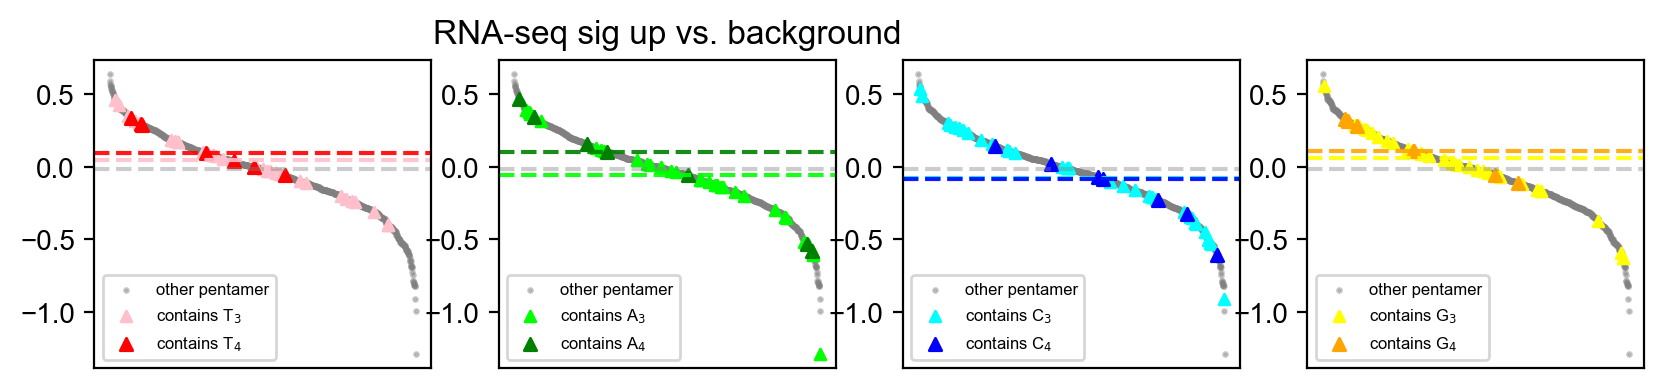

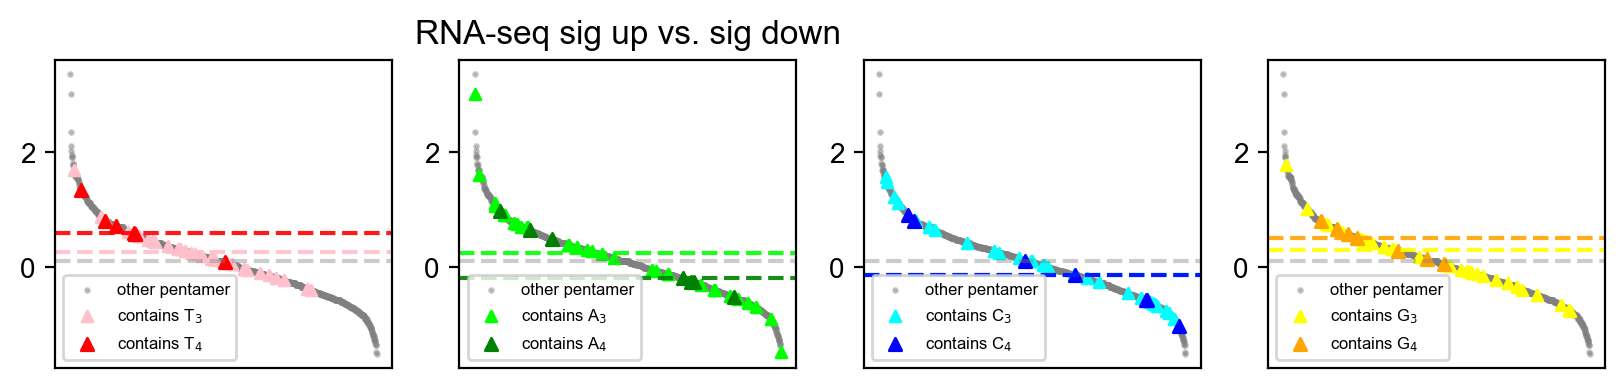

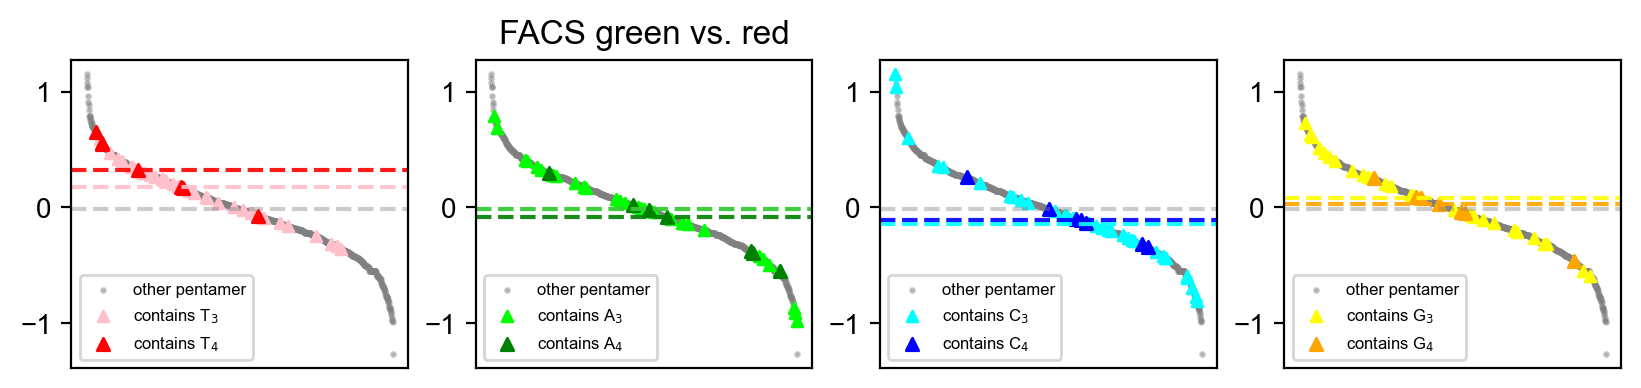

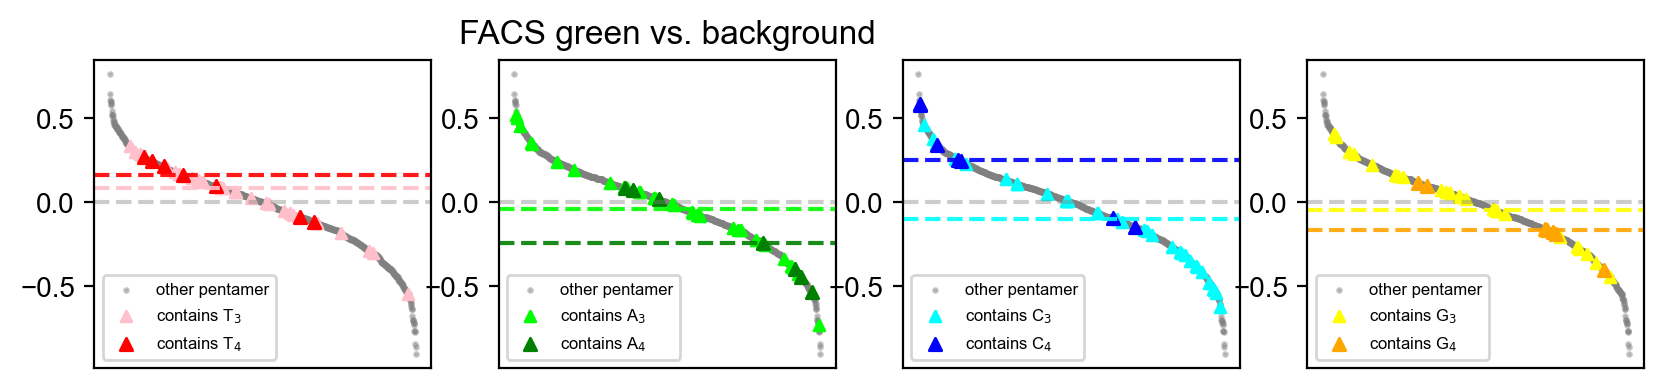

In [52]:
for j,rfdict in enumerate([up_non, 
                           up_down, 
                           green_red, 
                           green_non
                          ]):
    titles = ['RNA-seq sig up vs. background',
              'RNA-seq sig up vs. sig down',
             'FACS green vs. red',
             'FACS green vs. background']
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    axes[1].set_title(titles[j])
    rfset = sorted([(f,p) for p,f in rfdict.items()], reverse=True)
    
    for i,n in enumerate(['T','A','C','G']):
        
        axes[i].scatter(range(1024),[f for f,p in rfset], s=2, alpha=0.4, c='grey', label='other pentamer')
        
        threes = [f for f,p in rfset if n*3 in p]
        three_ids = [i for i,(f,p) in enumerate(rfset) if n*3 in p]
        
        axes[i].scatter(three_ids, threes, s=15, alpha=1, c=nuc_colors2[n], marker='^', label='contains %s$_3$' % n)
        
        fours = [f for f,p in rfset if n*4 in p]
        four_ids = [i for i,(f,p) in enumerate(rfset) if n*4 in p]
        
        axes[i].scatter(four_ids, fours, s=20, alpha=1, c=nuc_colors[n], marker='^', label='contains %s$_4$' %n)
        
        axes[i].axhline(np.median(threes), c=nuc_colors2[n], linestyle='--', alpha=0.9)
        axes[i].axhline(np.median(fours), c=nuc_colors[n], linestyle='--', alpha=0.9)
        axes[i].axhline(np.median([f for f,p in rfset]), c='grey',linestyle='--',alpha=0.4)
        
        axes[i].legend(fontsize=6, loc=3)
        
        axes[i].set_xticks([])
    plt.show()

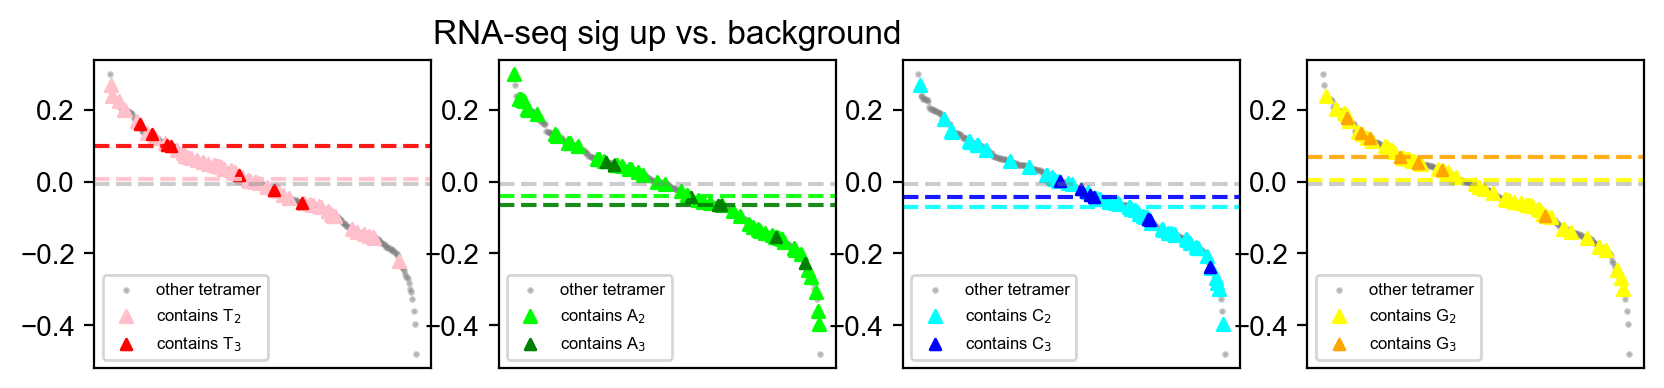

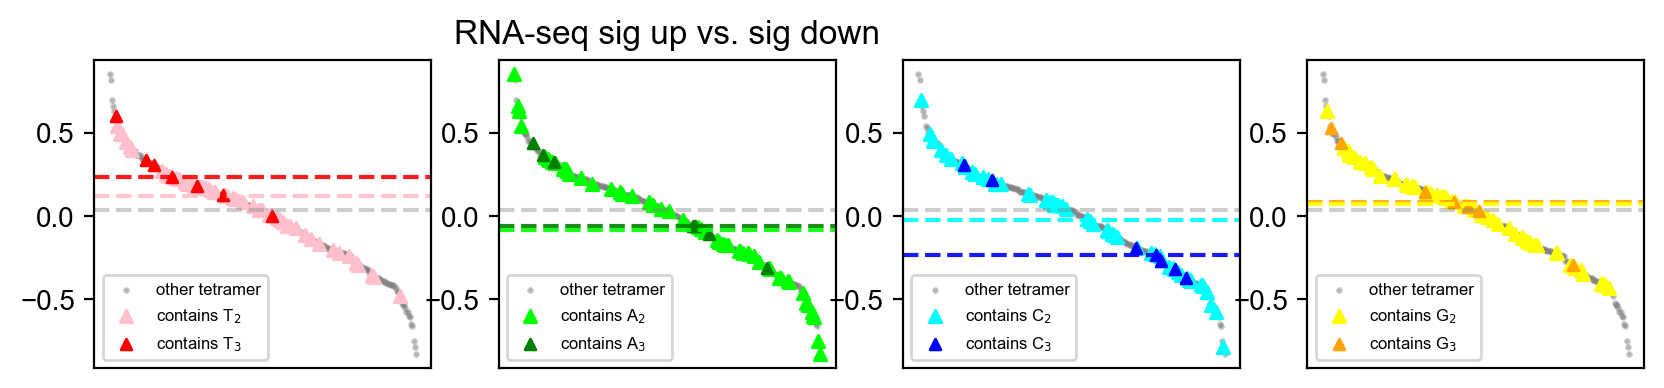

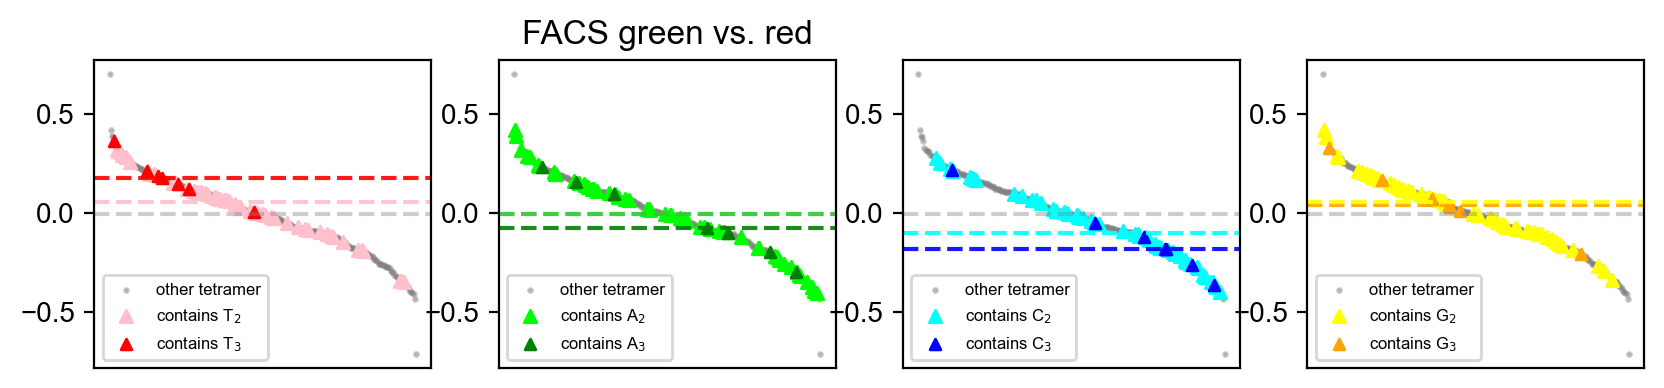

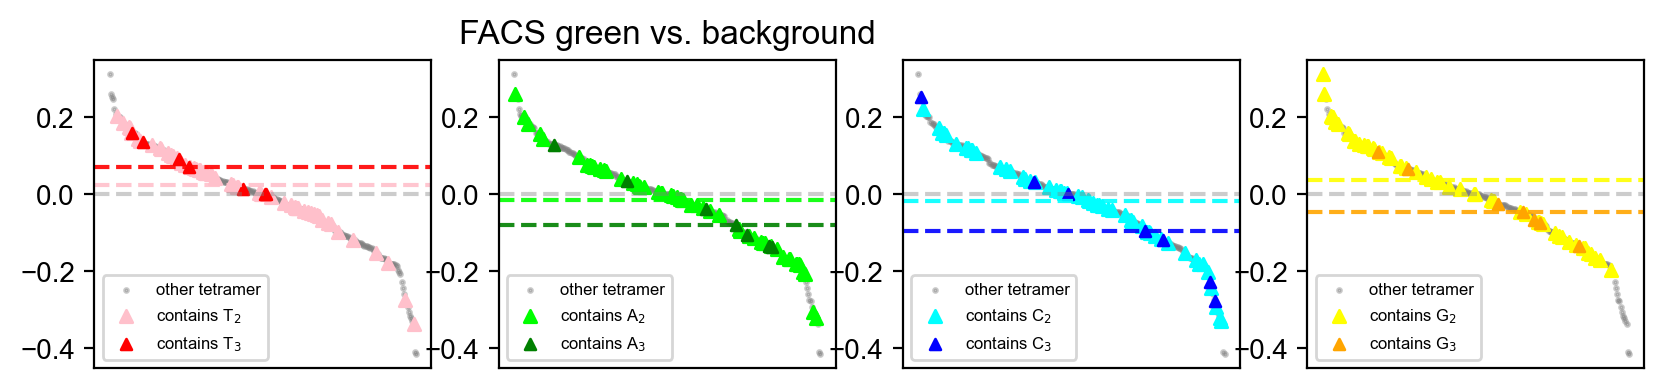

In [53]:
for j,rfdict in enumerate([up_non_4, 
                           up_down_4, 
                           green_red_4, 
                           green_non_4
                          ]):
    titles = ['RNA-seq sig up vs. background',
              'RNA-seq sig up vs. sig down',
             'FACS green vs. red',
             'FACS green vs. background']
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    axes[1].set_title(titles[j])
    rfset = sorted([(f,p) for p,f in rfdict.items()], reverse=True)
    
    for i,n in enumerate(['T','A','C','G']):
        
        axes[i].scatter(range(256),[f for f,p in rfset], s=2, alpha=0.4, c='grey', label='other tetramer')

        twos = [f for f,p in rfset if p.count(n)==2]
        two_ids = [i for i,(f,p) in enumerate(rfset) if p.count(n)==2]
        
        axes[i].scatter(two_ids, twos, s=20, alpha=1, c=nuc_colors2[n], marker='^', label='contains %s$_2$' %n)
        
        threes = [f for f,p in rfset if n*3 in p]
        three_ids = [i for i,(f,p) in enumerate(rfset) if n*3 in p]
        
        axes[i].scatter(three_ids, threes, s=15, alpha=1, c=nuc_colors[n], marker='^', label='contains %s$_3$' % n)
        
        axes[i].axhline(np.median(threes), c=nuc_colors[n], linestyle='--', alpha=0.9)
        axes[i].axhline(np.median(twos), c=nuc_colors2[n], linestyle='--', alpha=0.9)
        axes[i].axhline(np.median([f for f,p in rfset]), c='grey',linestyle='--',alpha=0.4)
        
        axes[i].legend(fontsize=6, loc=3)
        
        axes[i].set_xticks([])
    plt.show()

# cdfs of pentamer relative frequencies by composition

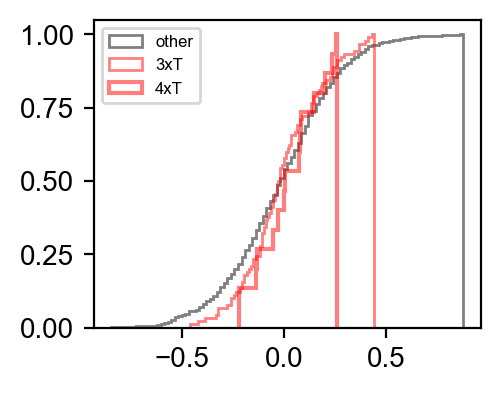

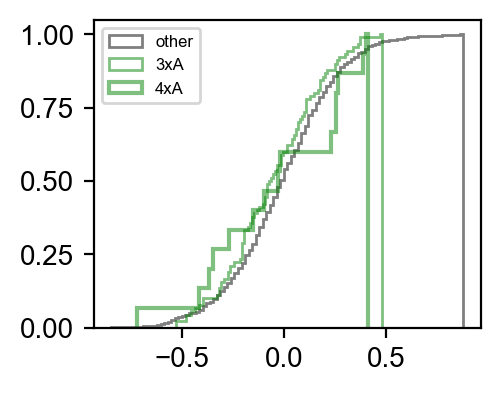

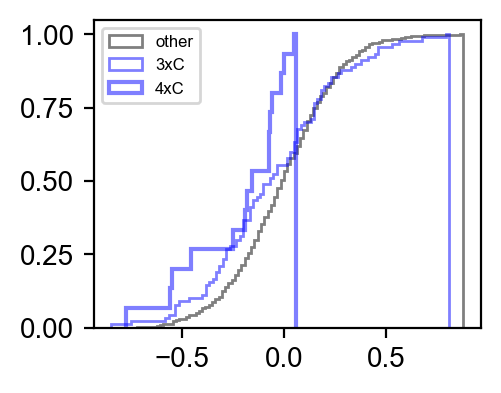

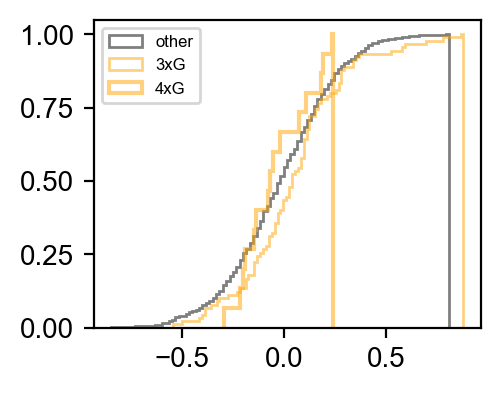

In [465]:
for nuc in ['T','A','C','G']:
    patches = {}
    
    plt.figure(figsize=(2.5,2))
    counts = [3,4]
    
    plt.hist([green_non[x] for x in pentamers if x.count(nuc)<min(counts)], 
                 color='k', bins=bins, cumulative=True, 
                 density=True, alpha=0.5, histtype='step', linewidth=1,
                 label=f'other')
    for i,n in enumerate(counts):
        plt.hist([green_non[x] for x in pentamers if x.count(nuc)==n], 
                 color=nuc_colors[nuc], bins=bins, cumulative=True, 
                 density=True, alpha=0.5, histtype='step', linewidth=(i+2)/2,
                 label=f'{n}x{nuc}')
        
    plt.legend(fontsize=6)
    plt.show()

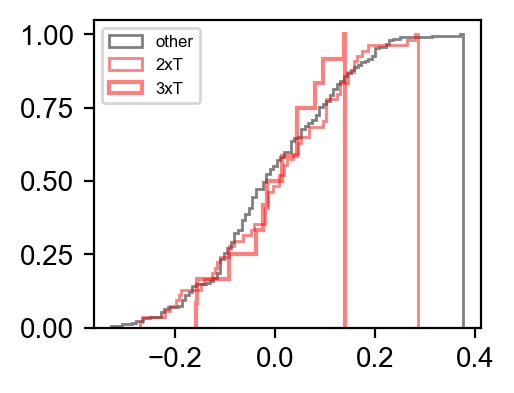

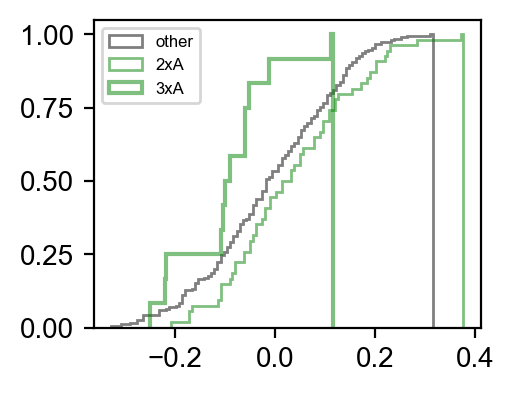

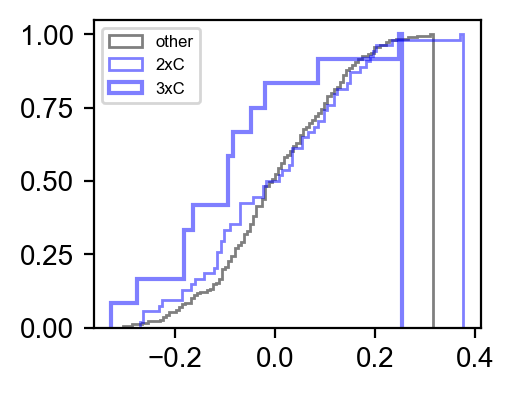

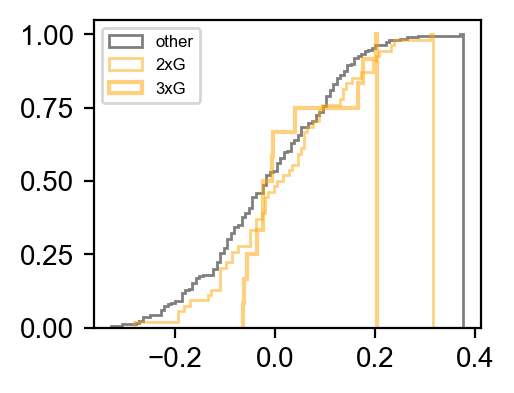

In [466]:
for nuc in ['T','A','C','G']:
    patches = {}
    
    plt.figure(figsize=(2.5,2))
    counts = [2,3]
    
    plt.hist([green_non_4[x] for x in tetramers if x.count(nuc)<min(counts)], 
                 color='k', bins=bins, cumulative=True, 
                 density=True, alpha=0.5, histtype='step', linewidth=1,
                 label=f'other')
    for i,n in enumerate(counts):
        plt.hist([green_non_4[x] for x in tetramers if x.count(nuc)==n], 
                 color=nuc_colors[nuc], bins=bins, cumulative=True, 
                 density=True, alpha=0.5, histtype='step', linewidth=(i+2)/2,
                 label=f'{n}x{nuc}')
        
    plt.legend(fontsize=6)
    plt.show()

# scatter plots of kmer enrichments

### functions

In [58]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from adjustText import adjust_text
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

TtoU = {'A':'A','C':'C','G':'G','T':'U'}

def scatter_rel_pentamer_freqs(dict1,dict2,names, 
                               kmers=pentamers,
                               annotate_pentamers=False,
                              legloc = 'upper left',
                              corrloc = (0.75, 0.05)):
    
    plt.figure(figsize=(3, 3.5))
    klen = len(kmers[0])

    kmers_plotted = []

    for nuc in ['A','C','G','T']:
        if klen==5:
            kmers_to_plot = [k for k in kmers if k.count(nuc)==(klen-2)]
            plt.scatter([dict1[k] for k in kmers_to_plot],
                        [dict2[k] for k in kmers_to_plot],
                        c=nuc_colors[nuc],
                        alpha=0.3, s=1, label=f'{TtoU[nuc]} = {klen-2}')
            kmers_plotted+=kmers_to_plot
        kmers_to_plot = [k for k in kmers if k.count(nuc)>=(klen-1)]
        plt.scatter([dict1[k] for k in kmers_to_plot],
                    [dict2[k] for k in kmers_to_plot],
                    c=nuc_colors[nuc],
                    alpha=0.6, s=4, label=f'{TtoU[nuc]} ≥ {klen-1}')
        kmers_plotted+=kmers_to_plot

    kmers_unplotted = [k for k in kmers if k not in kmers_plotted]
    plt.scatter([dict1[k] for k in kmers_unplotted],
            [dict2[k] for k in kmers_unplotted],
            c='lightgrey',
            alpha=0.4, s=1, label=f'other')

    plt.legend(fontsize=6, #bbox_to_anchor=(1.05,0.8)
              loc=legloc)
    
    # Add dotted lines at 0 on both axes
    plt.axhline(0, color='grey', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(0, color='grey', linestyle='--', alpha=0.5, linewidth=1)
    
    # Labels and title
    plt.xlabel(names[0])
    plt.ylabel(names[1])
    #plt.title('Scatter Plot of Pentamer Frequency Ratios')

    aligned_freqs1, aligned_freqs2 = [dict1[k] for k in kmers], [dict2[k] for k in kmers]
    coef, _ = stats.spearmanr(aligned_freqs1, aligned_freqs2)
    plt.annotate(f'$\\rho$={coef:.3f}', xy=corrloc, xycoords='axes fraction', fontsize=8)
    #plt.annotate(f'$R^2$={coef**2:.2f}', xy=(0.4, 0.05), xycoords='axes fraction')

    if annotate_pentamers==True:
        # Find the top 10 enriched pentamers above the y=-x diagonal
        # for pentamers at least 2fold enriched in each set
        
        top_right_indices = [i for i, (x, y) in enumerate(zip(aligned_freqs1, aligned_freqs2)) if x > 0 and y > 0]
        distances = np.abs(np.array([aligned_freqs1[i] for i in top_right_indices]) + np.array([aligned_freqs2[i] for i in top_right_indices])) / np.sqrt(2)
        top10_indices = np.argsort(distances)[::-1][:4]
        top10_pentamers = [kmers[top_right_indices[i]] for i in top10_indices]
        top10_x = [aligned_freqs1[top_right_indices[i]] for i in top10_indices]
        top10_y = [aligned_freqs2[top_right_indices[i]] for i in top10_indices]

        # Annotate top 10 pentamers in the top right quadrant with lines
        annotations = []
        for x, y, p in zip(top10_x, top10_y, top10_pentamers):
            annotation = plt.annotate(
                p, 
                xy=(x, y), 
                xytext=(x,y), 
                textcoords='offset points',
                fontsize=6, 
                alpha=0.7,
                arrowprops=dict(arrowstyle='-', color='grey', lw=0.5)
            )
            annotations.append(annotation)
            
        # Adjust text to avoid overlap
        #adjust_text(annotations)

    # ANNOTATE POLYU
    #polyU = 'T'*klen
    #x,y = dict1[polyU], dict2[polyU]
    #plt.annotate(polyU,
    #            xy=(x, y), 
    #            xytext=(x+1,y+25), 
    #            textcoords='offset points',
    #            fontsize=6, 
    #            alpha=0.7,
    #            arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
        
    # Show plot
    plt.show()

### plots

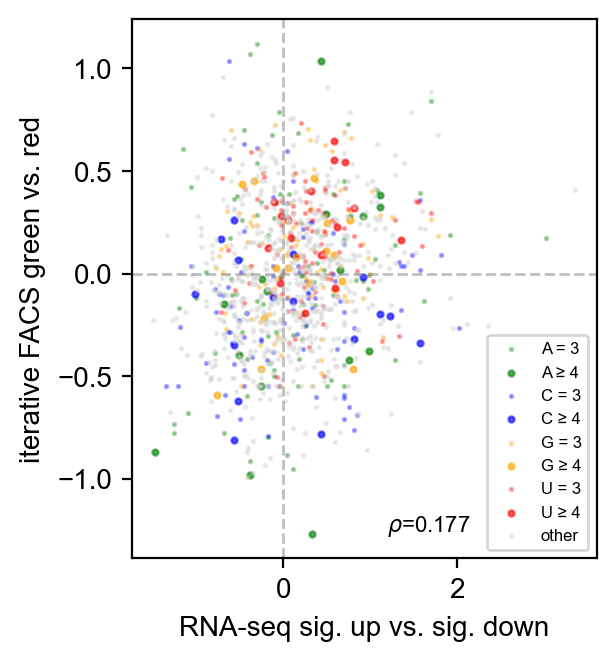

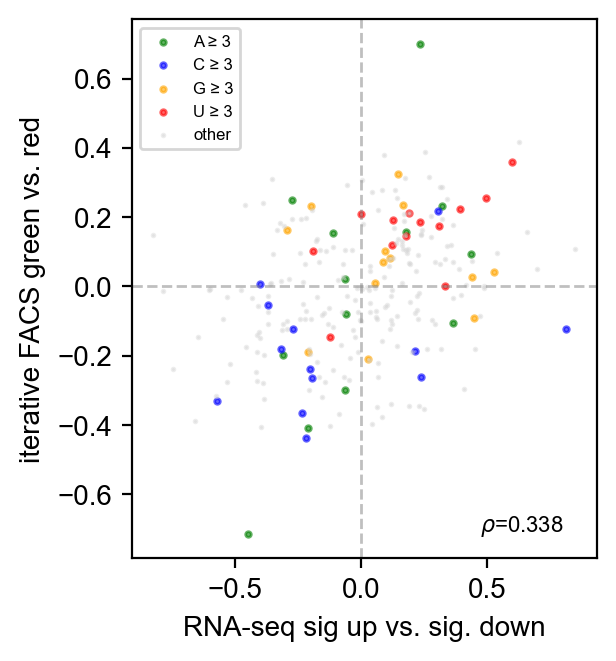

In [59]:
scatter_rel_pentamer_freqs(up_down,green_red,['RNA-seq sig. up vs. sig. down',
                                          'iterative FACS green vs. red'],
                          legloc='lower right', corrloc = (0.55, 0.05))


scatter_rel_pentamer_freqs(up_down_4,green_red_4,['RNA-seq sig up vs. sig. down',
                                         'iterative FACS green vs. red'],
                         kmers=tetramers)

In [57]:
#scatter_rel_pentamer_freqs(up_non_bc,up_down_bc,['RNA-seq sig up vs. nonsignificant',
#                                          'RNA-seq sig up vs. sig. down'],
#                          annotate_pentamers=True,
#                          kmers=pentamers_H)
#
#scatter_rel_pentamer_freqs(green_non_bc,green_red_bc,['FACS sig up vs. nonsignificant',
#                                          'FACS sig up vs. sig. down'],
#                          annotate_pentamers=True,
#                          kmers=pentamers_H)
#
#scatter_rel_pentamer_freqs(up_down_bc,green_red_bc,['RNA-seq sig up vs. sig. down',
#                                          'FACS sig up vs. sig. down'],
#                          annotate_pentamers=True,
#                          kmers=pentamers_H)
#
#scatter_rel_pentamer_freqs(up_non_bc,green_non_bc,['RNA-seq sig up vs. nonsignificant',
#                                          'FACS sig up vs. nonsignificant'],
#                          annotate_pentamers=True,
#                          kmers=pentamers_H)

# other shit

In [147]:
up_down

{'AAAAA': 0.015304860997905645,
 'AAAAC': 0.6750449433382859,
 'AAAAG': 0.6129624345674287,
 'AAAAT': -0.3713106923534537,
 'AAACA': 0.2698776880835033,
 'AAACC': 0.228298584332104,
 'AAACG': 0.3803016777771539,
 'AAACT': -0.07090943405517507,
 'AAAGA': -0.10763636854913766,
 'AAAGC': 0.4474158736356907,
 'AAAGG': -0.09362951055525852,
 'AAAGT': -0.1342714950526042,
 'AAATA': -0.6592266864094835,
 'AAATC': -0.1451598111953407,
 'AAATG': -0.47032069818461925,
 'AAATT': 0.19222932962458206,
 'AACAA': 0.6058613781922848,
 'AACAC': -0.22541938311079948,
 'AACAG': 0.05837358288979143,
 'AACAT': -0.08499059228138575,
 'AACCA': 0.5178052015270888,
 'AACCC': 0.536420879694436,
 'AACCG': -0.08747728357366337,
 'AACCT': -0.1260509882476357,
 'AACGA': -0.24118669896911626,
 'AACGC': 0.5178052015270888,
 'AACGG': -0.07090943405517507,
 'AACGT': -0.09690464258811932,
 'AACTA': -0.2977702273354838,
 'AACTC': 0.3063010963333772,
 'AACTG': -0.3328171744346844,
 'AACTT': -0.15021303892162607,
 'AAGAA':

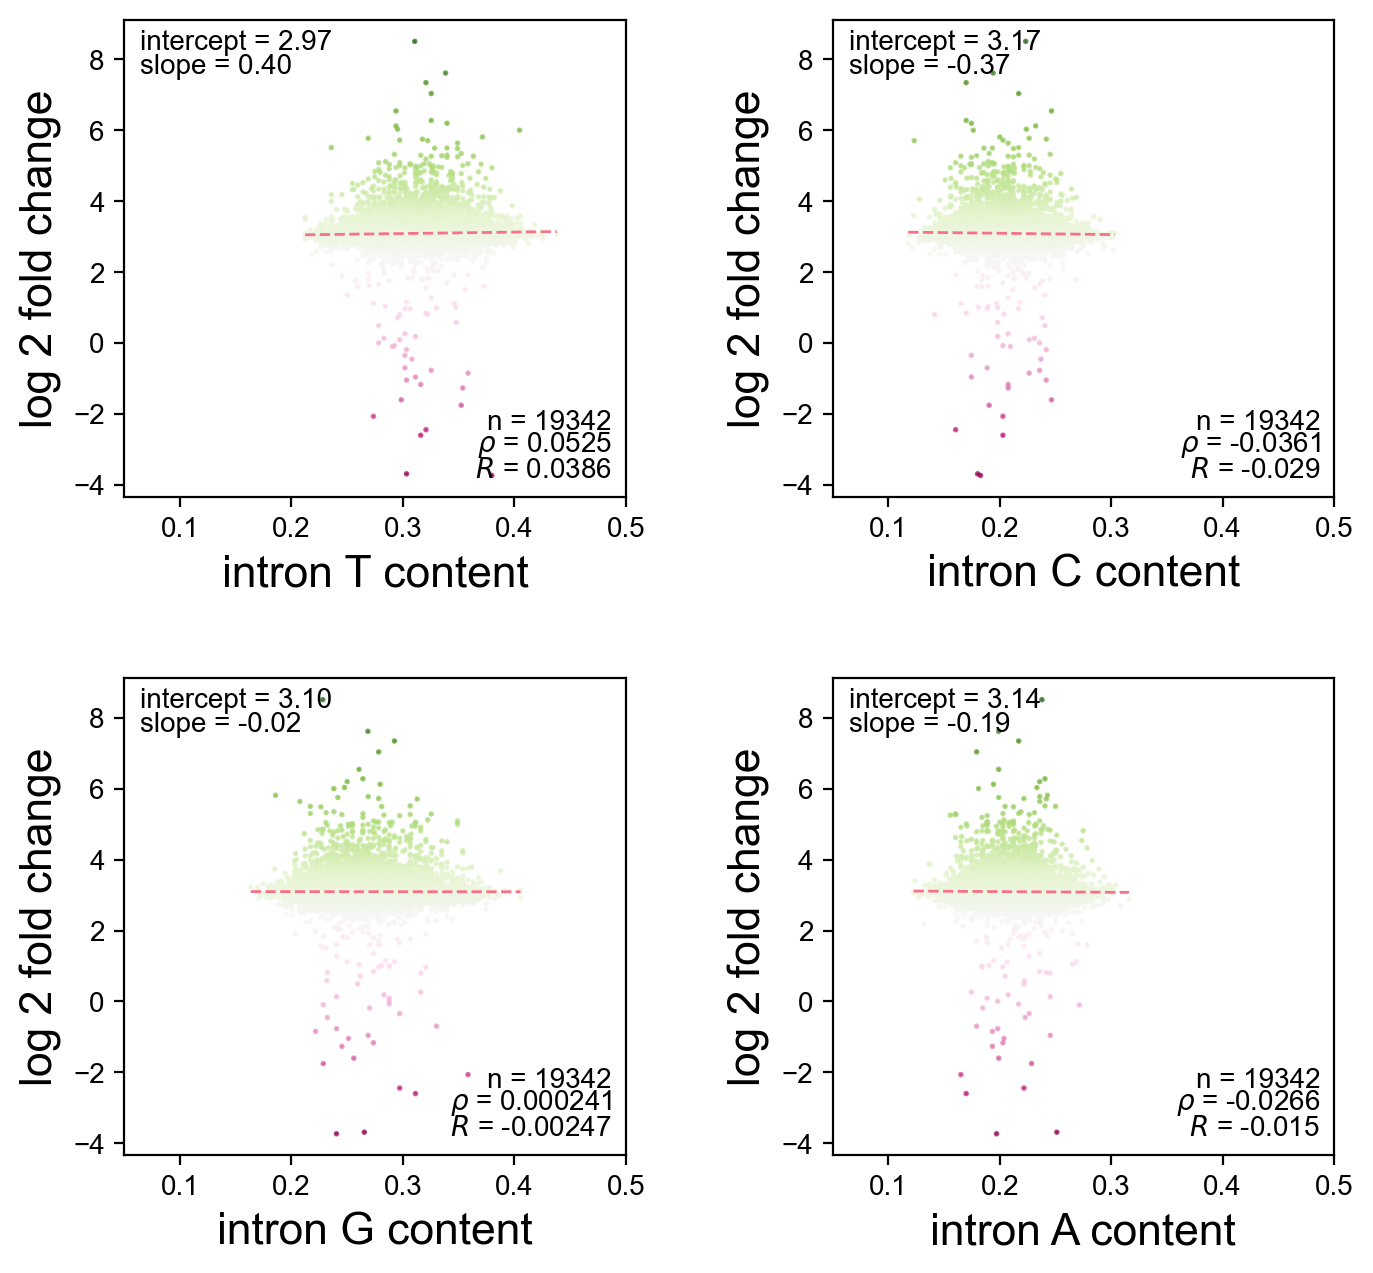

In [65]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(7.5,7)
cmap = plt.get_cmap('PiYG')

j,k = 0,0

for i in [0,1,2,3]:
    
    nuc = dna[3-i]
    
    xdata = [percent_N(nuc,b2i[b]) for b in np.array(bcs)[~i_msk]]
    ydata = norm_l2fc[~i_msk]
    #bcGCs = [gc(i2b[b][0][0]) for b in random_ints]
    
    axes[j,k].scatter(xdata,ydata,
                    alpha=0.7,s=1,c=ydata, cmap=cmap)
        
    axes[j,k].set_xlabel('intron %s content' % nuc, fontsize=16, fontweight='medium')
    axes[j,k].set_ylabel('log 2 fold change', fontsize=16, fontweight='medium')
    axes[j,k].set_xlim(0.05,0.5)
    axes[j,k].set_xticks(np.arange(0.1,0.6,0.1))
    
    axes[j,k].annotate('n = %i' % len(xdata), size=10, xy=(1, 0.10), 
                 xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
    axes[j,k].annotate('$\\rho$ = %s' % float('%.3g' % stats.spearmanr(xdata,ydata)[0]),size=10, xy=(1, 0.05), 
                 xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
    axes[j,k].annotate('$R$ = %s' % float('%.3g' % (stats.pearsonr(xdata,ydata)[0])),size=10, xy=(1, 0), 
                 xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')

    reg = sp.stats.linregress(xdata,ydata)
    x_vals = np.linspace(min(xdata),max(xdata))
    y_vals = reg.intercept+(reg.slope*x_vals)
    axes[j,k].plot(x_vals, y_vals, '--', linewidth=1)
    axes[j,k].annotate('slope = %.2f' % reg.slope, size=10, xy=(0.06, 0.9), 
                 xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='left', va='top')
    axes[j,k].annotate('intercept = %.2f' % reg.intercept, size=10, xy=(0.06, 0.95), 
                 xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='left', va='top')

    plt.tight_layout(pad=3.0)
    
    if i%2==0:
        k+=1
    else:
        j+=1
        k-=1
    
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=axes, ticks=[0,0.5,1], shrink=0.6)
#cbar.ax.set_yticklabels([0.0,0.5,1.0], size=10)
#cbar.set_label('barcode GC content')

plt.show()

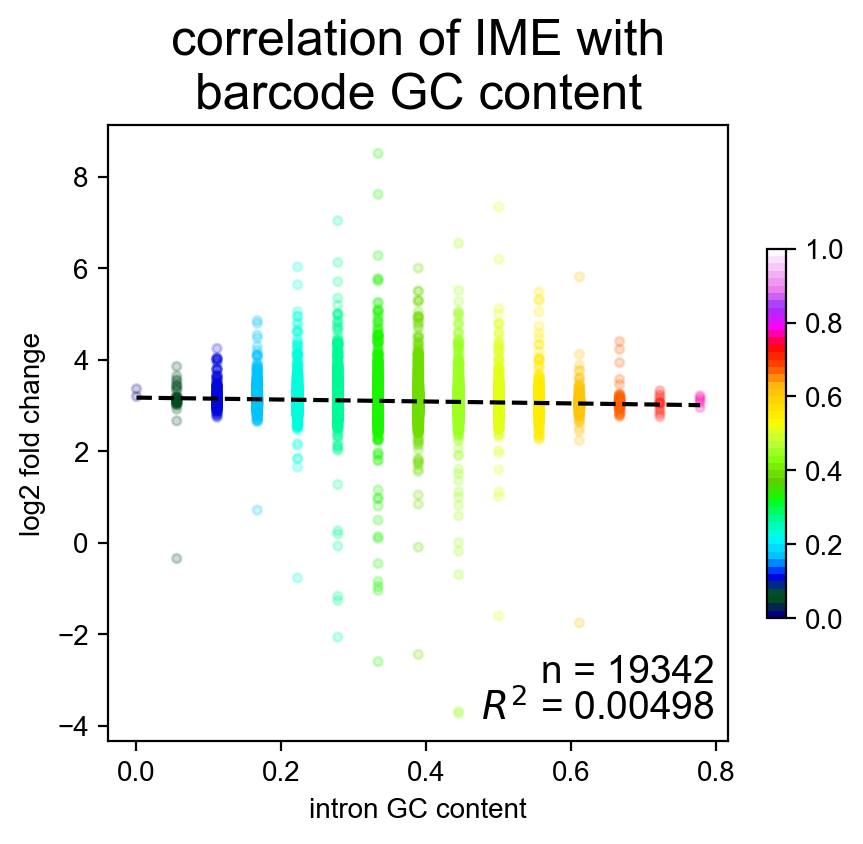

In [66]:
xdata = [gc(b) for b in np.array(bcs)[~i_msk]]
ydata = norm_l2fc[~i_msk]

cmap = plt.get_cmap('gist_ncar', 50)

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(xdata,ydata,
            alpha=0.2,s=10,
            c=cmap(xdata)
           )

plt.title('correlation of IME with\nbarcode GC content',size=18)
plt.xlabel('intron GC content', fontweight='medium')
plt.ylabel('log2 fold change', fontweight='medium')
plt.annotate('n = %i' % len(xdata), size=14, xy=(1, 0.06), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')
plt.annotate('$R^2$ = %s' % float('%.3g' % (stats.pearsonr(xdata,ydata)[0])**2),
             size=14, xy=(1, 0), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, shrink=0.6)

reg = sp.stats.linregress(xdata,ydata)
x_vals = np.linspace(min(xdata),max(xdata))
y_vals = reg.intercept+(reg.slope*x_vals)
plt.plot(x_vals, y_vals, '--',c='black')

plt.show()

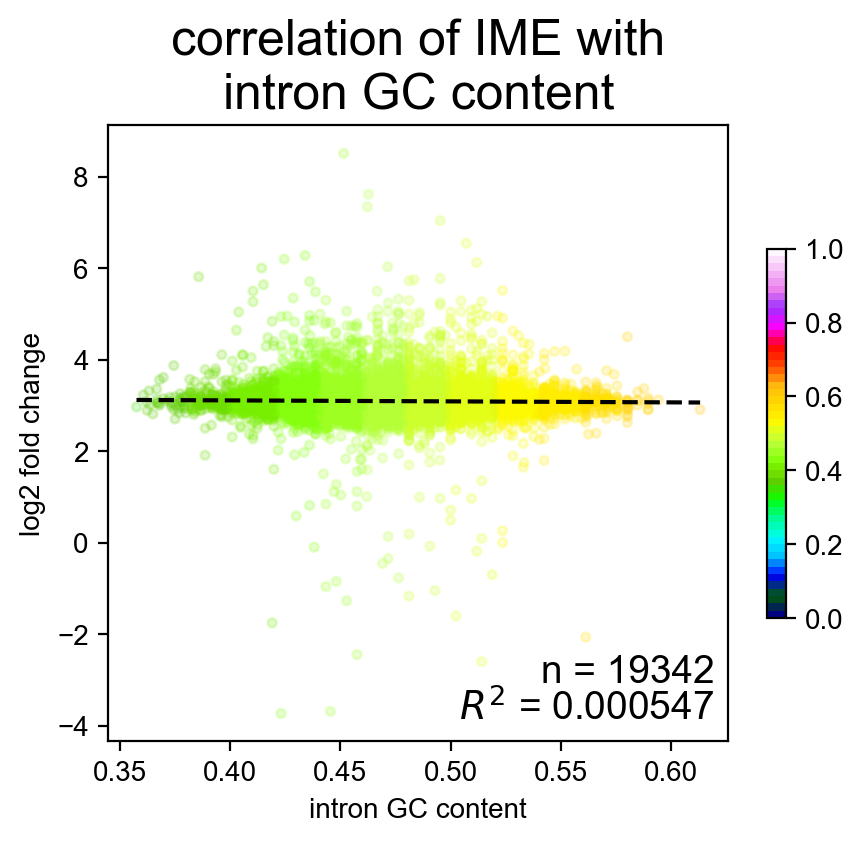

In [67]:
xdata = [gc(b2i[b]) for b in np.array(bcs)[~i_msk]]
ydata = norm_l2fc[~i_msk]

cmap = plt.get_cmap('gist_ncar', 50)

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(xdata,ydata,
            alpha=0.2,s=10,
            c=cmap(xdata)
           )

plt.title('correlation of IME with\nintron GC content',size=18)
plt.xlabel('intron GC content', fontweight='medium')
plt.ylabel('log2 fold change', fontweight='medium')
plt.annotate('n = %i' % len(xdata), size=14, xy=(1, 0.06), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')
plt.annotate('$R^2$ = %s' % float('%.3g' % (stats.pearsonr(xdata,ydata)[0])**2),
             size=14, xy=(1, 0), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, shrink=0.6)

reg = sp.stats.linregress(xdata,ydata)
x_vals = np.linspace(min(xdata),max(xdata))
y_vals = reg.intercept+(reg.slope*x_vals)
plt.plot(x_vals, y_vals, '--',c='black')

plt.show()

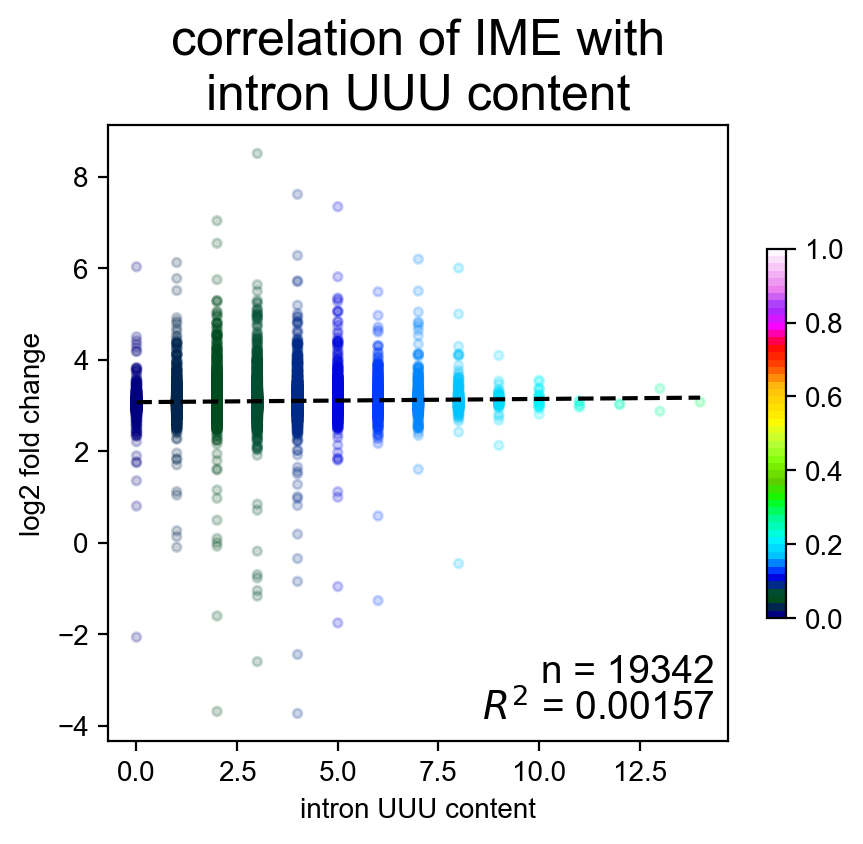

In [68]:

xdata = [b2i[b].count('TTT') for b in np.array(bcs)[~i_msk]]
ydata = norm_l2fc[~i_msk]

cmap = plt.get_cmap('gist_ncar', 50)

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(xdata,ydata,
            alpha=0.2,s=10,
            c=cmap(xdata)
           )

plt.title('correlation of IME with\nintron UUU content',size=18)
plt.xlabel('intron UUU content', fontweight='medium')
plt.ylabel('log2 fold change', fontweight='medium')
plt.annotate('n = %i' % len(xdata), size=14, xy=(1, 0.06), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')
plt.annotate('$R^2$ = %s' % float('%.3g' % (stats.pearsonr(xdata,ydata)[0])**2),
             size=14, xy=(1, 0), 
             xycoords='axes fraction', xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom',
             fontweight='medium')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, shrink=0.6)

reg = sp.stats.linregress(xdata,ydata)
x_vals = np.linspace(min(xdata),max(xdata))
y_vals = reg.intercept+(reg.slope*x_vals)
plt.plot(x_vals, y_vals, '--',c='black')

plt.show()

# metaplots

In [60]:
seqlen=160

def get_abs_motif_positions(seq, motif):
    pos = []
    for i in range(seqlen):
        if seq[i:i+len(motif)] == motif:
            pos.append(i)
    return pos

def get_normed_motif_frequencies(intset, motif):
    motif_counts = []
    for s in intset:
        motif_counts.append(get_abs_motif_positions(s, motif))
    motif_counts = flatten(motif_counts)    # collapse motif instances into one big list for each set
    
    # get total counts at each position in order & normalize to # of introns that length or longer
    normed_frequencies = []
    for i in range(seqlen):
        set_size = len([s for s in intset if len(s)>i])
        if set_size>0:
            normed_frequencies.append(motif_counts.count(i)/set_size)

    return normed_frequencies

def get_binned_motif_frequencies(intset, motif, break_num):
    normed_freqs = get_normed_motif_frequencies(intset, motif)
    binned_freqs = []
    breakpoints = [int(i) for i in np.linspace(0,seqlen,break_num)]
    for x in range(len(breakpoints)-1):
        binned_freqs.append(np.sum(normed_freqs[breakpoints[x]:breakpoints[x+1]]))
    return binned_freqs

def get_relative_binned_motif_frequencies(intset1, intset2, motif, break_num):
    f1 = get_binned_motif_frequencies(intset1, motif, break_num)
    f2 = get_binned_motif_frequencies(intset2, motif, break_num)
    return [np.log2(x/y) for (x,y) in zip(f1,f2)]

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def get_relative_motif_frequencies(intset, background_set, motif, window):
    normed_frequencies = get_normed_motif_frequencies(intset, motif)
    bg_frequencies = get_normed_motif_frequencies(background_set, motif)
    rel_freqs = np.log2(running_mean(normed_frequencies,window) / running_mean(bg_frequencies,window))
    return rel_freqs

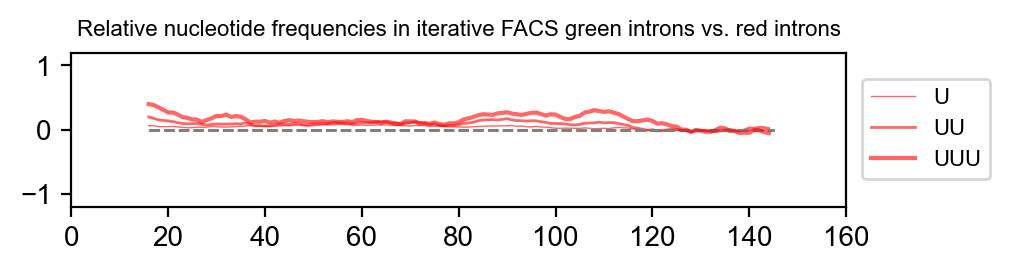

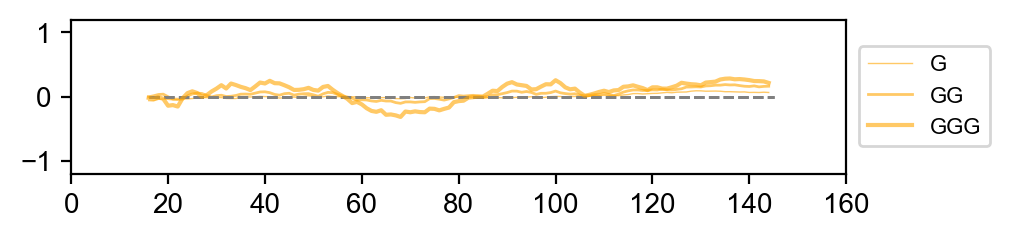

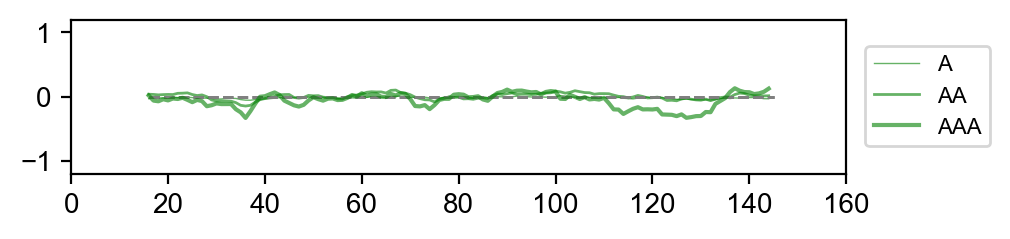

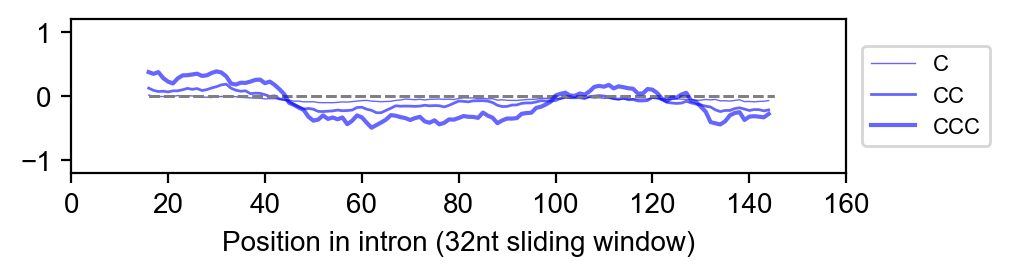

In [61]:
window = 32
sig_intsets = [[b2i[b][12:-40] for b in green_bcs if b in b2i],
               [b2i[b][12:-40] for b in red_bcs if b in b2i]]

for motif in ['T','G','A','C']:
    fig = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,1))
    for i in range(1,4):
        
        ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], motif*i, window)
        plt.hlines(0, xmin=0, xmax=len(ydata), color='grey', linewidth=1, linestyle = '--')
        plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=0.5*i, color=nuc_colors[motif], label=TtoU[motif]*i)
                    
                    
    #plt.xlabel('position in intron (%int sliding window anchored to 5\' end)' % window)
    #plt.ylabel(f'log2 ratio of poly{motif} frequency')
    #plt.title('%s frequency across intron length in sig. up introns vs. non-sig' % motif)
    plt.ylim(-1.2,1.2)
    plt.xlim(-window/2, 160-window/2)
    ticks = np.arange(-window/2,160,20)
    plt.xticks(ticks,
          [f'{x+window/2:.0f}' for x in ticks])

    plt.legend(fontsize=8, bbox_to_anchor=(1.2,0.9))
    if motif=='T':
        plt.title('Relative nucleotide frequencies in iterative FACS green introns vs. red introns', fontsize=8)
    if motif=='C':
         plt.xlabel('Position in intron (%int sliding window)' % window)
    plt.show()

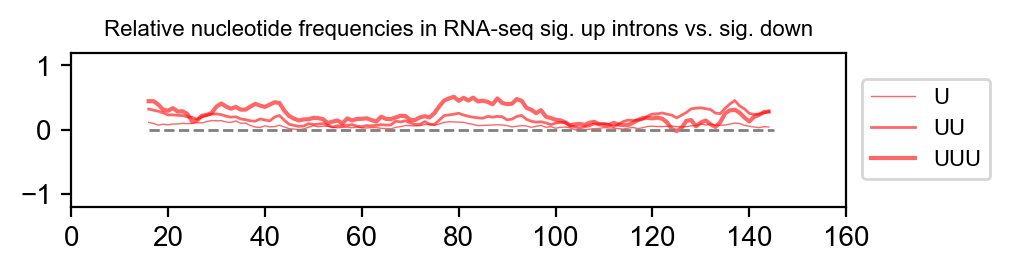

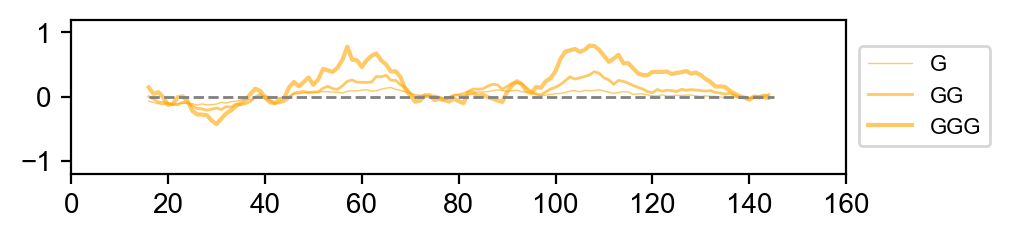

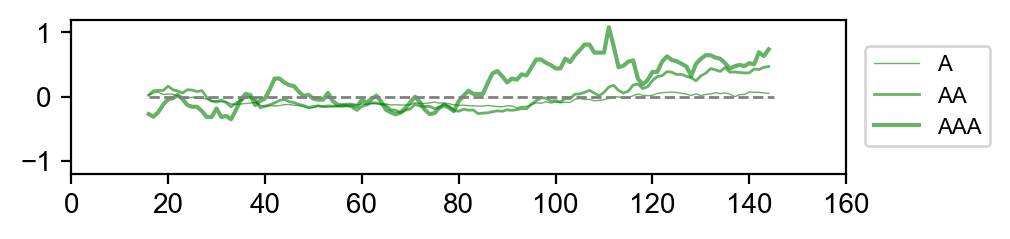

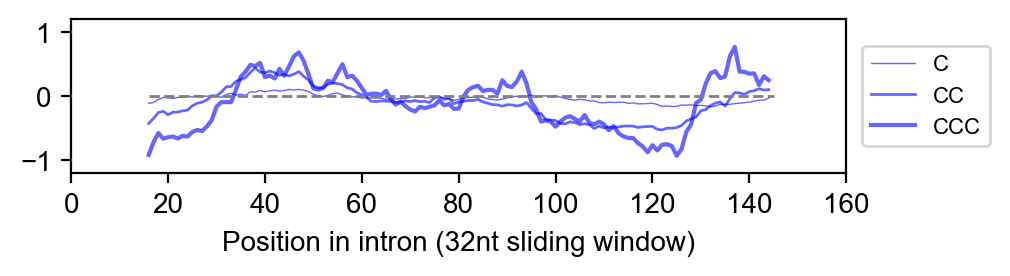

In [62]:
window = 32
sig_intsets = [[b2i[b][12:-40] for b in up_bcs],
               [b2i[b][12:-40] for b in down_bcs]]

for motif in ['T','G','A','C']:
    fig = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,1))
    for i in range(1,4):
        ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], motif*i, window)
        plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=0.5*i, color=nuc_colors[motif], label=TtoU[motif]*i)
    plt.hlines(0, xmin=0, xmax=len(ydata), color='grey', linewidth=1, linestyle = '--')
                    
    #plt.ylabel(f'log2 ratio of poly{motif} frequency')
    #plt.title('%s frequency across intron length in sig. up introns vs. non-sig' % motif)
    if motif=='T':
        plt.title('Relative nucleotide frequencies in RNA-seq sig. up introns vs. sig. down', fontsize=8)
    if motif=='C':
        plt.xlabel('Position in intron (%int sliding window)' % window)
    
    plt.ylim(-1.2,1.2)
    plt.legend(fontsize=8, bbox_to_anchor=(1.2,0.9))

    plt.xlim(-window/2, 160-window/2)
    ticks = np.arange(-window/2,160,20)
    plt.xticks(ticks,
          [f'{x+window/2:.0f}' for x in ticks])
    
    plt.show()

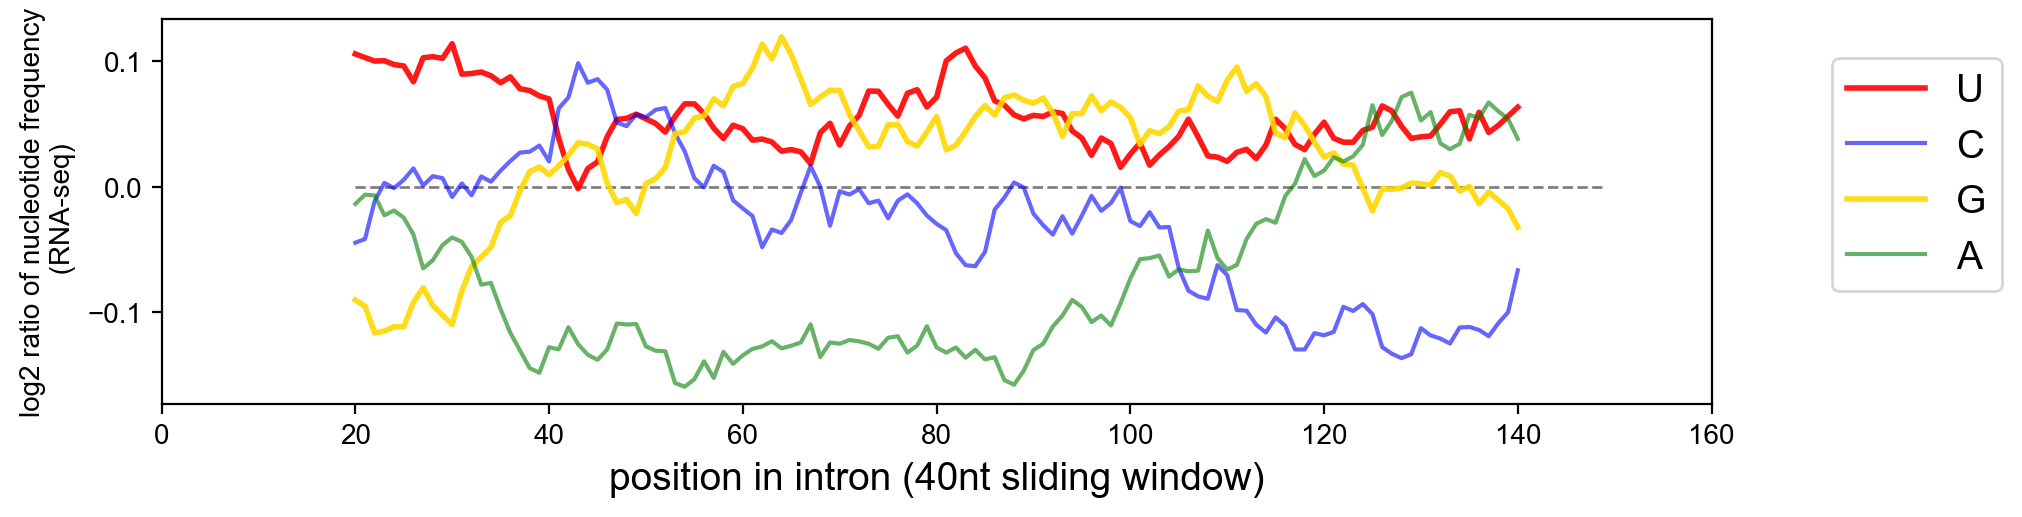

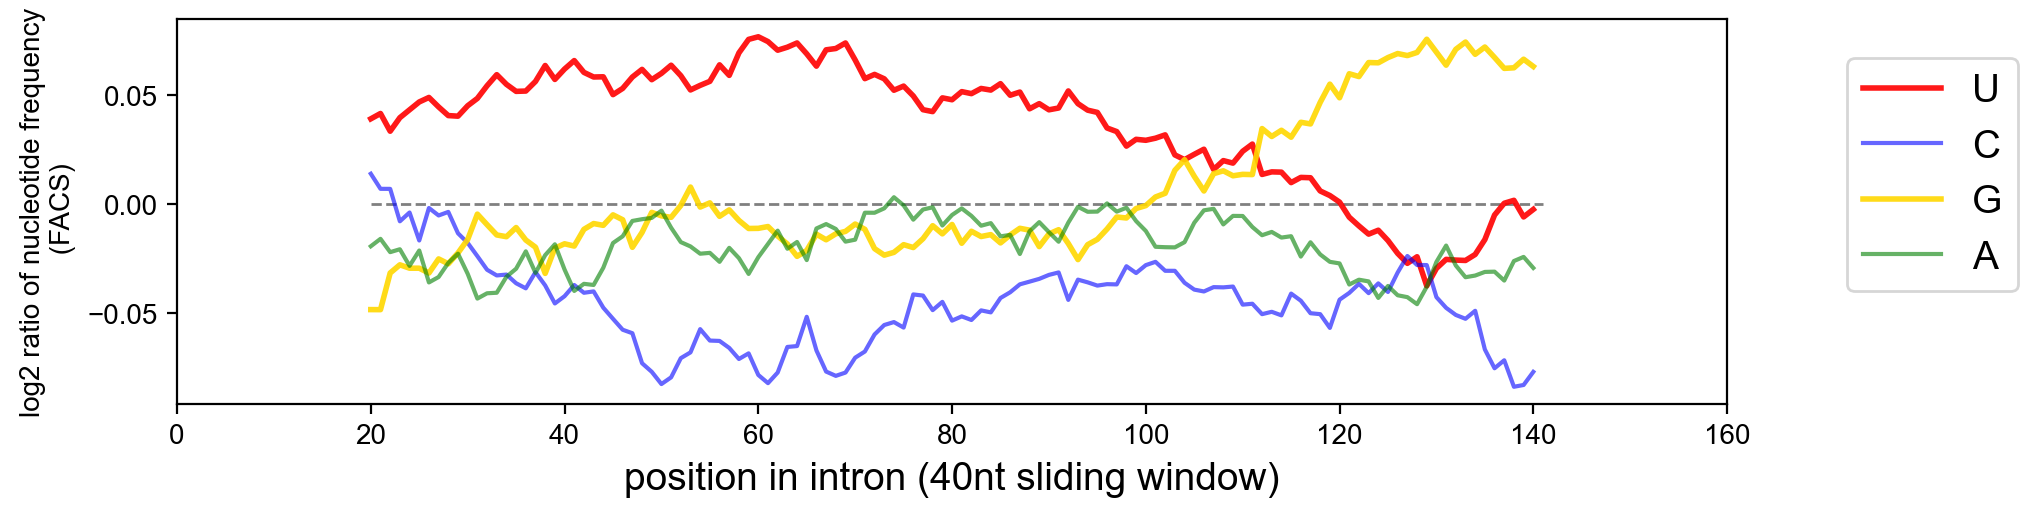

In [63]:
window = 40
n=1

sig_intsets = [[b2i[b][12:-40] for b in up_bcs], 
               [b2i[b][12:-40] for b in down_bcs]]
fig = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,2.5))
plt.hlines(0, xmin=0, xmax=len(ydata), color='grey', linewidth=1, linestyle = '--')  
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'T'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.9, linewidth=2, color='red', label='U'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'C'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=1.5, color='blue', label='C'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'G'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.9, linewidth=2, color='gold', label='G'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'A'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=1.5, color='green', label='A'*n)       
plt.xlabel('position in intron (%int sliding window)' % window, fontsize=14)
plt.ylabel('log2 ratio of nucleotide frequency\n (RNA-seq)')
#plt.ylim(-0.12,0.12)
plt.xlim(-window/2, 160-window/2)
ticks = np.arange(-window/2,160,20)
plt.xticks(ticks,[f'{x+window/2:.0f}' for x in ticks])
plt.legend(fontsize=14, bbox_to_anchor=(1.2,0.95))
plt.show()


sig_intsets = [[b2i[b][12:-40] for b in green_bcs if b in b2i], 
               [b2i[b][12:-40] for b in red_bcs if b in b2i]]
fig = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,2.5))
plt.hlines(0, xmin=0, xmax=len(ydata), color='grey', linewidth=1, linestyle = '--')  
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'T'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.9, linewidth=2, color='red', label='U'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'C'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=1.5, color='blue', label='C'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'G'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.9, linewidth=2, color='gold', label='G'*n)
ydata = get_relative_motif_frequencies(sig_intsets[0], sig_intsets[1], 'A'*n, window)
plt.plot(range(len(ydata)), ydata, alpha=0.6, linewidth=1.5, color='green', label='A'*n)       
plt.xlabel('position in intron (%int sliding window)' % window, fontsize=14)
plt.ylabel('log2 ratio of nucleotide frequency\n (FACS)')
#plt.ylim(-0.12,0.12)
plt.xlim(-window/2, 160-window/2)
ticks = np.arange(-window/2,160,20)
plt.xticks(ticks,[f'{x+window/2:.0f}' for x in ticks])
plt.legend(fontsize=14, bbox_to_anchor=(1.2,0.95))
plt.show()

## linear model using intron pentamer content

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [65]:
Xs = intron_pentamers.loc[bcs]
y = norm_l2fc

In [66]:
LR = LinearRegression()
LR.fit(Xs, y)
print('Rsq of basic linear regression is %.4f' % LR.score(Xs, y))

Rsq of basic linear regression is 0.0644


In [67]:
import random
random.shuffle(y)

LR = LinearRegression()
LR.fit(Xs, y)
print('Rsq of shuffled control linear regression is %.4f' % LR.score(Xs, y))

Rsq of shuffled control linear regression is 0.0500


In [391]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('')

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
coeff_df = pd.DataFrame(LR.coef_, Xs.columns, columns=['Coefficient'])  
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print('top 10 predictors:')
print(coeff_df.head(10))
print('')
print('bottom 10 predictors:')
print(coeff_df.tail(10))

Mean Absolute Error: 0.1777075612634125
Mean Squared Error: 0.10053196680067143
Root Mean Squared Error: 0.3170677637361948

top 10 predictors:
       Coefficient
TCTAG     0.154781
TCTAC     0.150313
AAAGG     0.139833
CATAA     0.139814
ACCGT     0.137888
TCTAT     0.136238
AAAGT     0.126665
CCCGT     0.126608
AATAA     0.126549
TCTAA     0.123951

bottom 10 predictors:
       Coefficient
GAACT    -0.112051
CAAAG    -0.113738
ATCTA    -0.113803
TTTCA    -0.118089
TCATG    -0.118735
TTCTA    -0.122199
ATAAA    -0.125225
CCGTT    -0.133572
CTCTA    -0.133752
GTCTA    -0.149701


In [392]:
from sklearn import linear_model

for alpha in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(Xs, y)
    print('alpha: %f' % alpha)
    print('lasso Rsq: %.4f' % lasso.score(Xs, y))
    print('')

alpha: 1.000000
lasso Rsq: 0.0000

alpha: 0.100000
lasso Rsq: 0.0000

alpha: 0.010000
lasso Rsq: 0.0000

alpha: 0.001000
lasso Rsq: 0.0202

alpha: 0.000100
lasso Rsq: 0.0507

alpha: 0.000010
lasso Rsq: 0.0668

